In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [ ]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

oil_tickers_names = {'CL=F':'Crude Oil',
                     'NG=F':'Natural Gas'}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
for symbol, name in oil_tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('stock_data.csv', index = False)


# Inspect Data

## General

In [132]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6261 entries, 0 to 6260
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   6261 non-null   object        
 1   company  6261 non-null   object        
 2   date     6261 non-null   datetime64[ns]
 3   open     6261 non-null   float64       
 4   high     6261 non-null   float64       
 5   low      6261 non-null   float64       
 6   close    6261 non-null   float64       
 7   volume   6261 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 391.4+ KB
None


In [133]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           6261  6261.000000  6261.000000  6261.000000   
mean   2023-01-29 04:30:00.862481920    64.072924    64.803652    63.315287   
min              2021-01-04 00:00:00     1.533000     1.628000     1.481000   
25%              2022-01-13 00:00:00    29.987559    30.309042    29.870398   
50%              2023-01-30 00:00:00    61.101624    61.524346    60.572976   
75%              2024-02-13 00:00:00    93.140349    94.660004    92.089996   
max              2025-02-27 00:00:00   169.405669   171.723297   168.554636   
std                              NaN    45.011324    45.473819    44.516405   

             close        volume  
count  6261.000000  6.261000e+03  
mean     64.067464  7.683511e+06  
min       1.575000  0.000000e+00  
25%      30.103643  3.337600e+05  
50%      61.063206  5.890400e+06  
75%      93.176537  1.122440e+07  
ma

In [134]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Natural Gas    1045
Crude Oil      1044
ExxonMobil     1043
Shell          1043
Chevron        1043
BP             1043
Name: count, dtype: int64


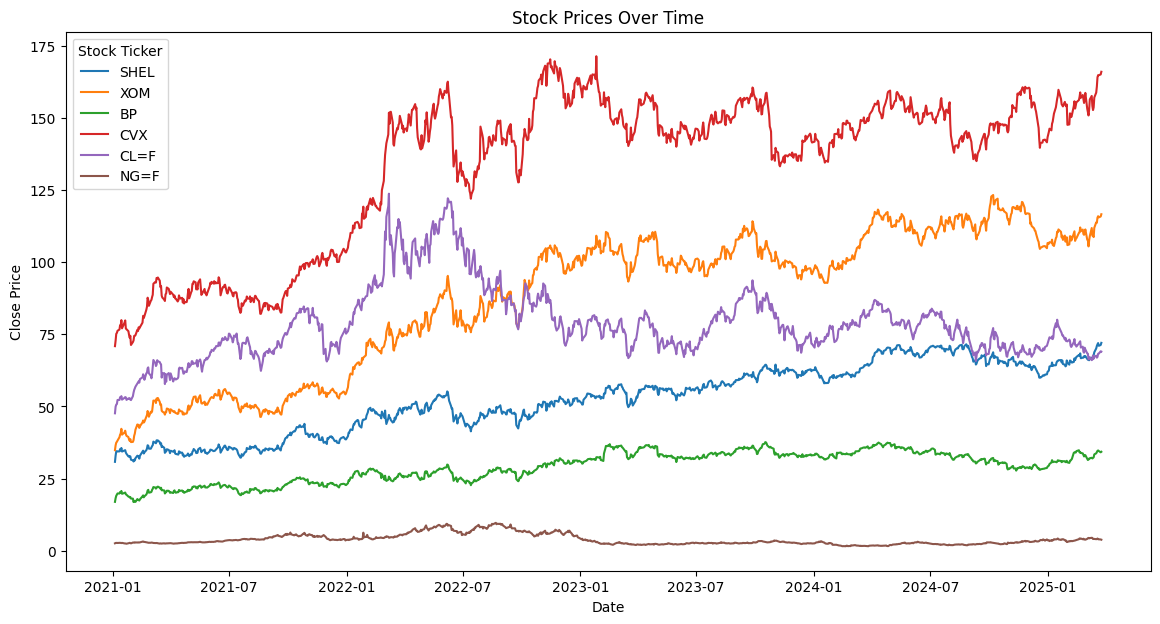

In [108]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.show()

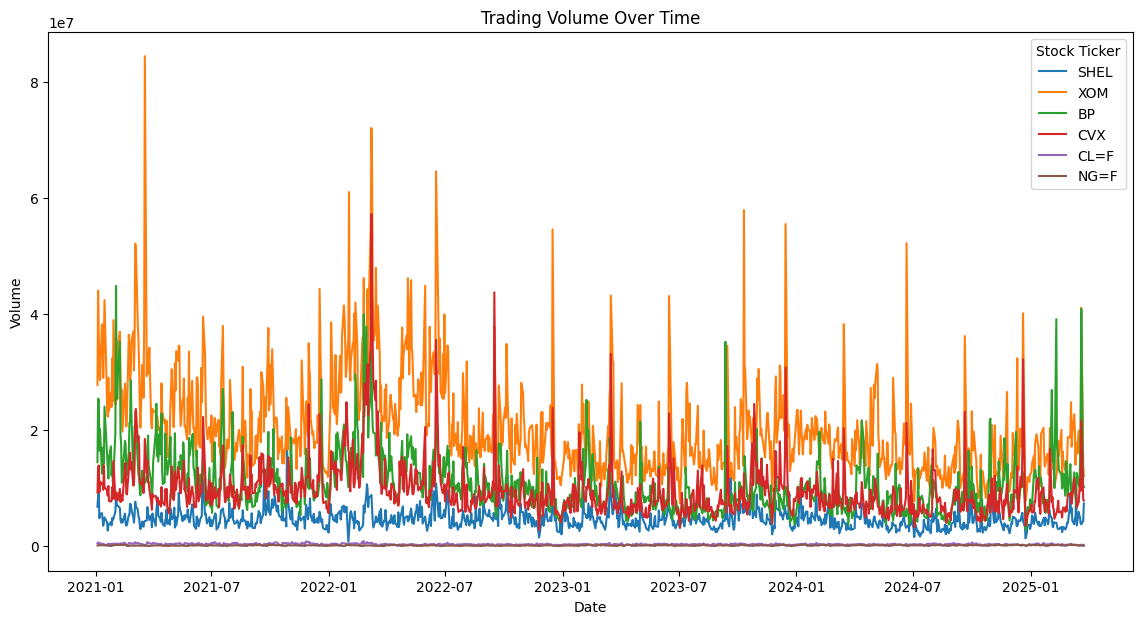

In [109]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.show()

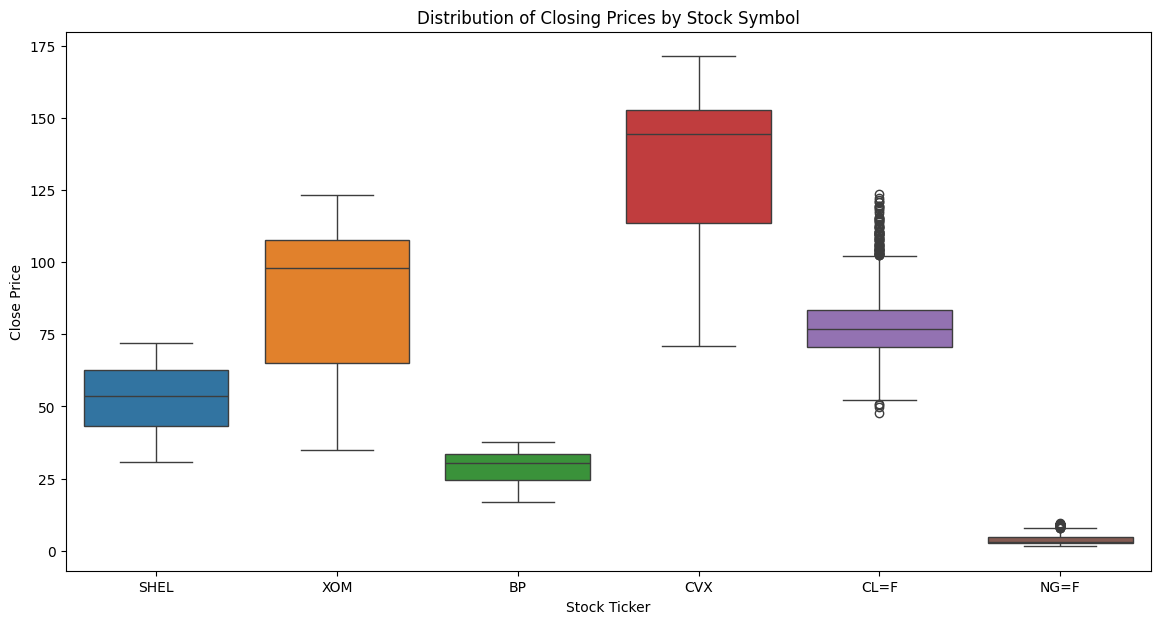

In [110]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.show()

In [111]:
# pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
# pivot_table

pivot_table = stock_data.reset_index().pivot(index='date', columns='ticker', values='close')
pivot_table


ticker             BP       CL=F         CVX   NG=F       SHEL         XOM
date                                                                      
2021-01-04  16.946371  47.619999   70.881577  2.581  30.810038   34.851482
2021-01-05  18.207386  49.930000   72.797752  2.702  32.930744   36.531075
2021-01-06  19.045343  50.630001   75.140678  2.716  34.452862   37.463249
2021-01-07  19.452122  50.830002   75.492119  2.729  34.495605   37.757172
2021-01-08  19.850769  52.240002   76.211739  2.700  34.410107   38.177067
...               ...        ...         ...    ...        ...         ...
2025-03-19  34.610001  67.160004  164.050003  4.247  71.519997  115.410004
2025-03-20  34.750000  68.260002  164.770004  3.975  71.949997  115.900002
2025-03-21  34.549999  68.279999  164.750000  3.980  71.010002  115.500000
2025-03-24  34.110001  69.110001  165.020004  3.914  71.279999  115.800003
2025-03-25  34.290001  69.000000  165.940002  3.840  72.029999  116.589996

[1063 rows x 6 columns]

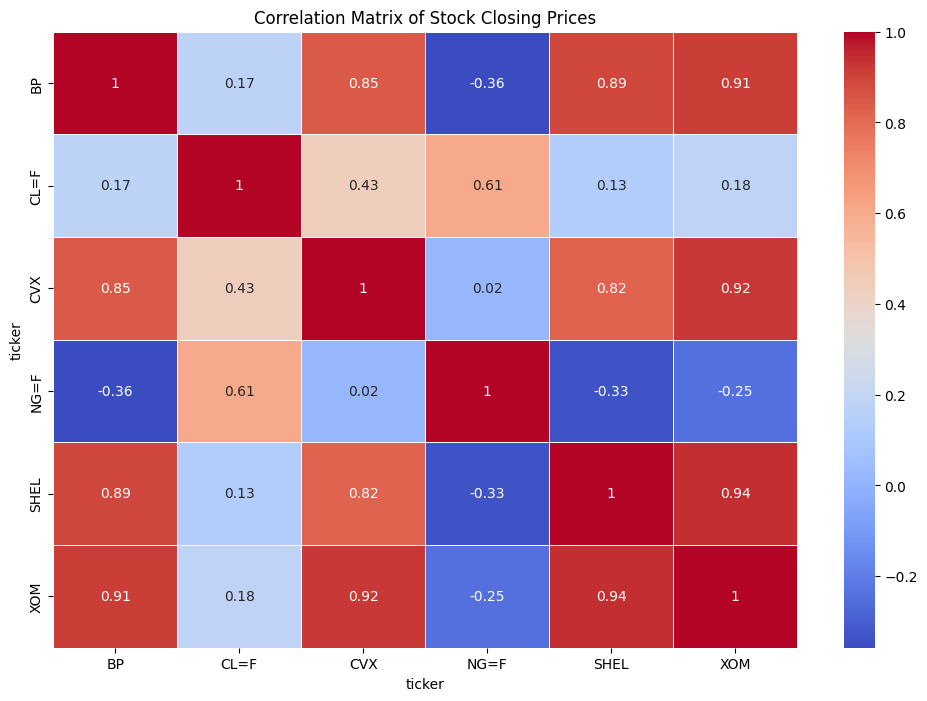

In [112]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.show()

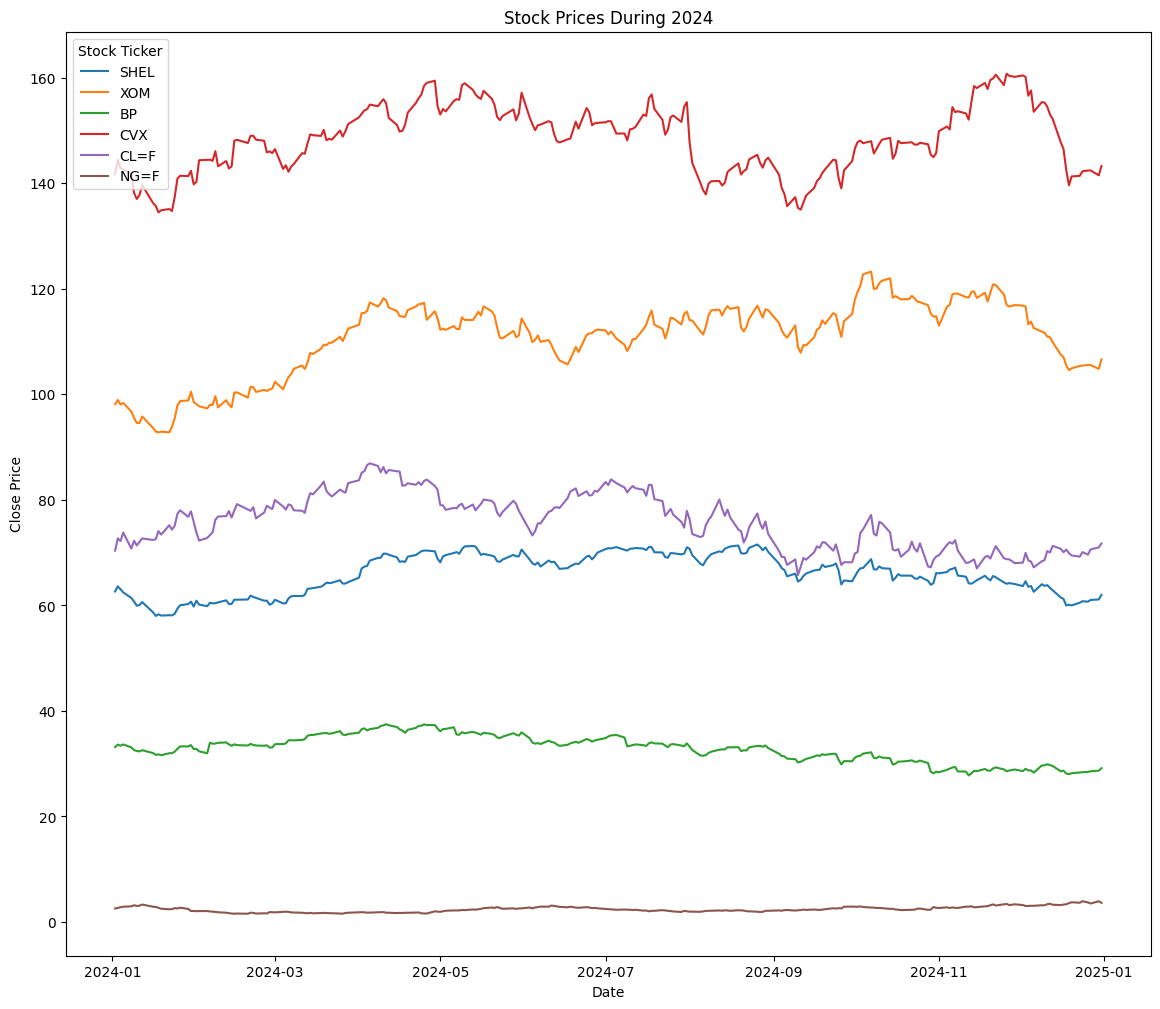

In [113]:
stock_data_2024 = stock_data.reset_index()[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.show()

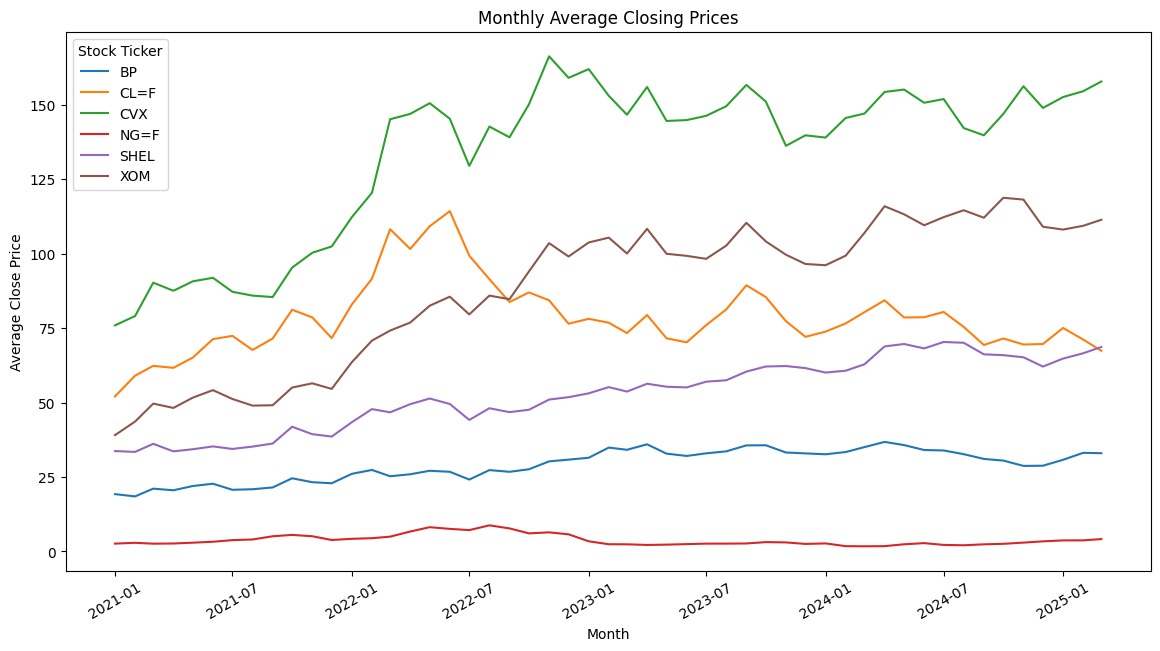

In [114]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.show()

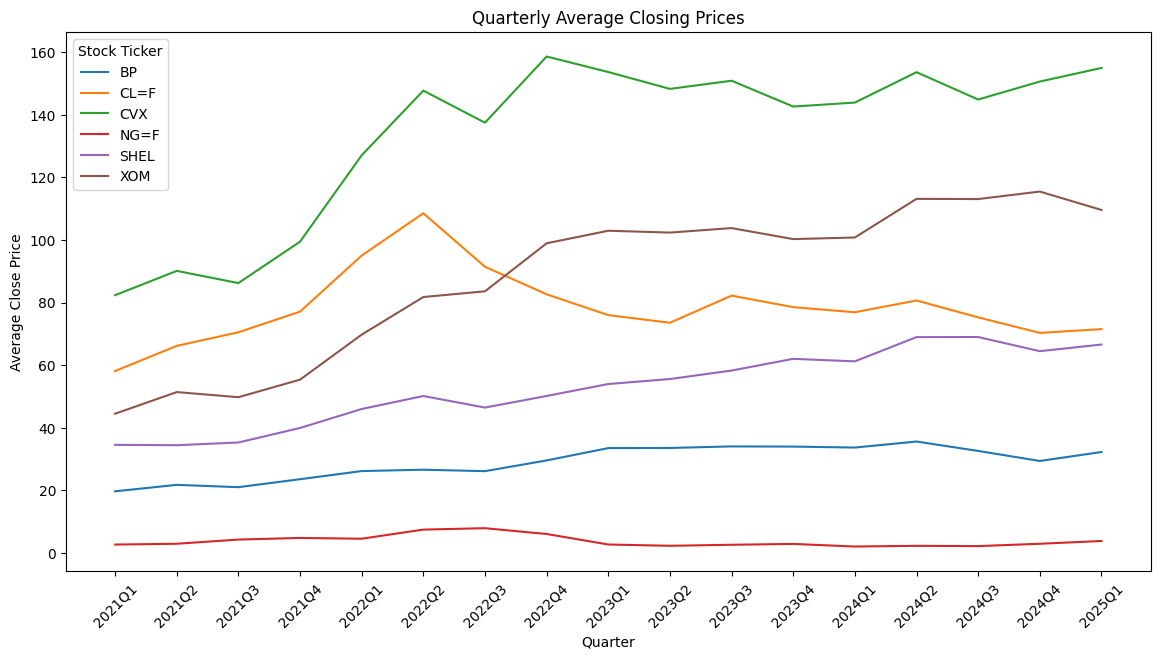

In [115]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.show()

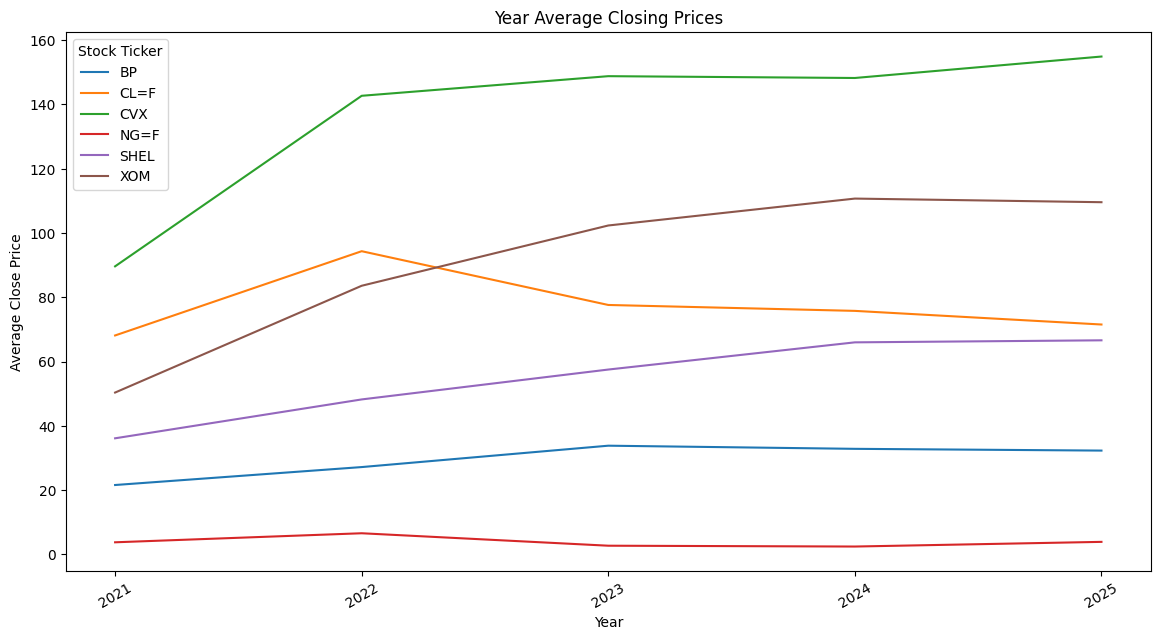

In [116]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.show()

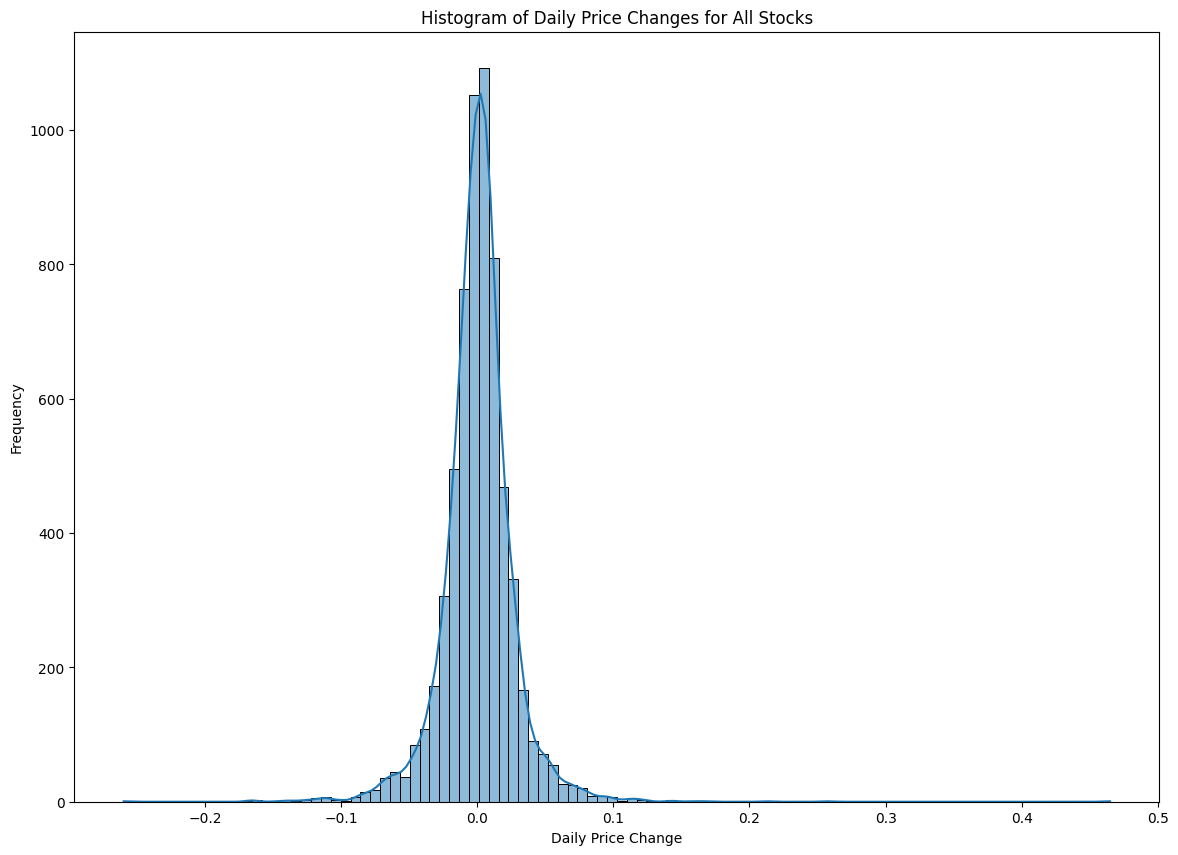

In [117]:
stock_data['price_change'] = stock_data.groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.show()

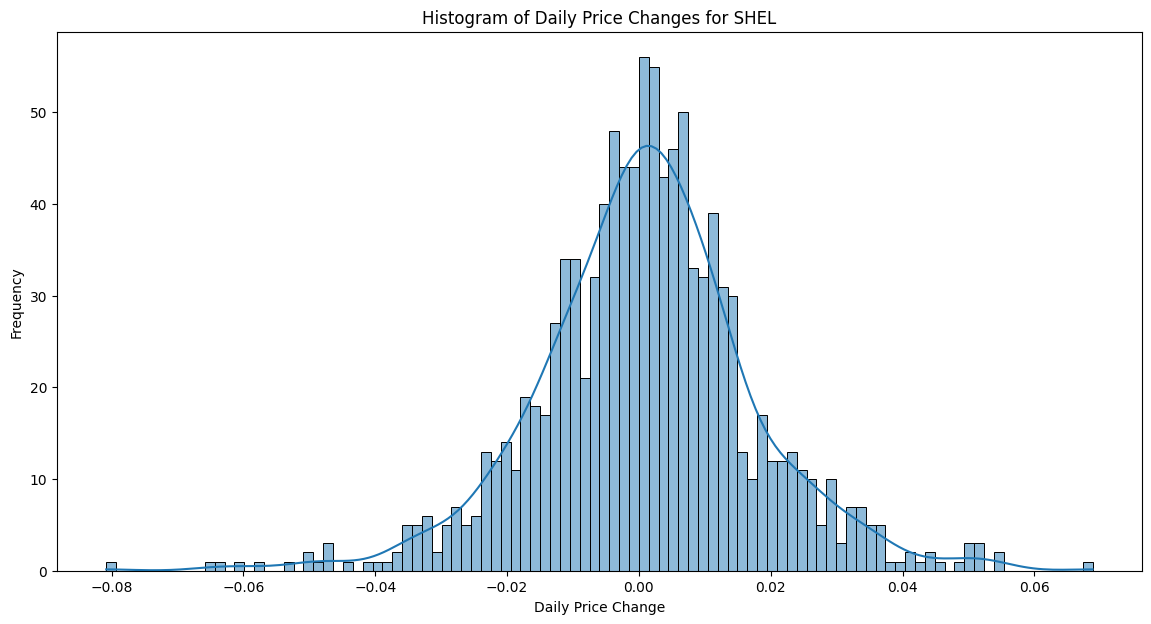

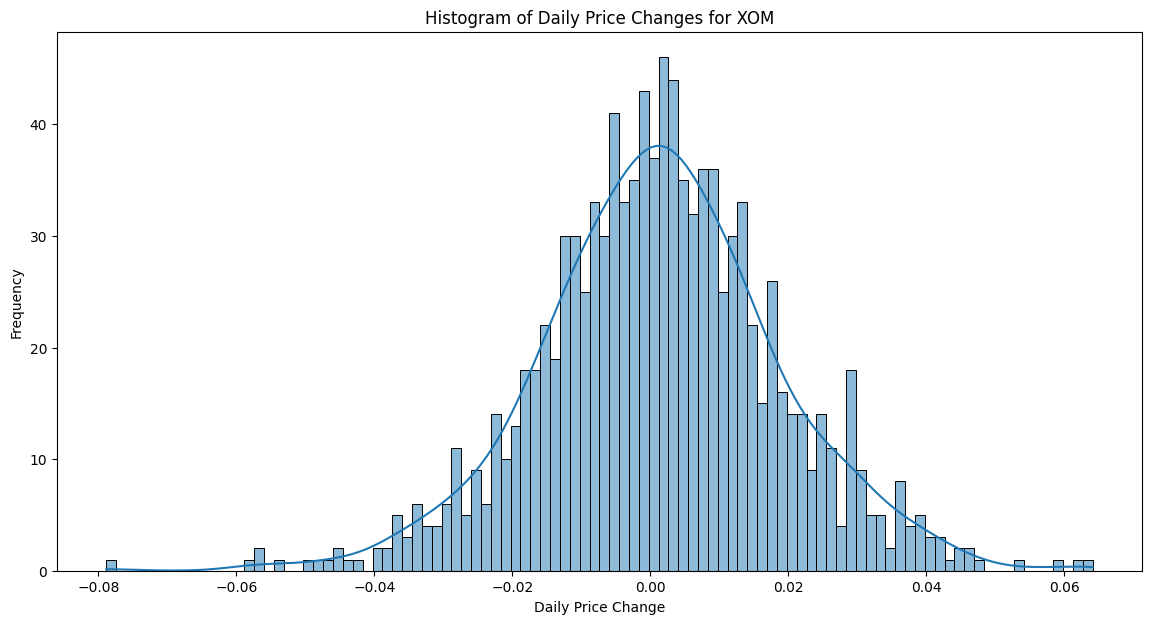

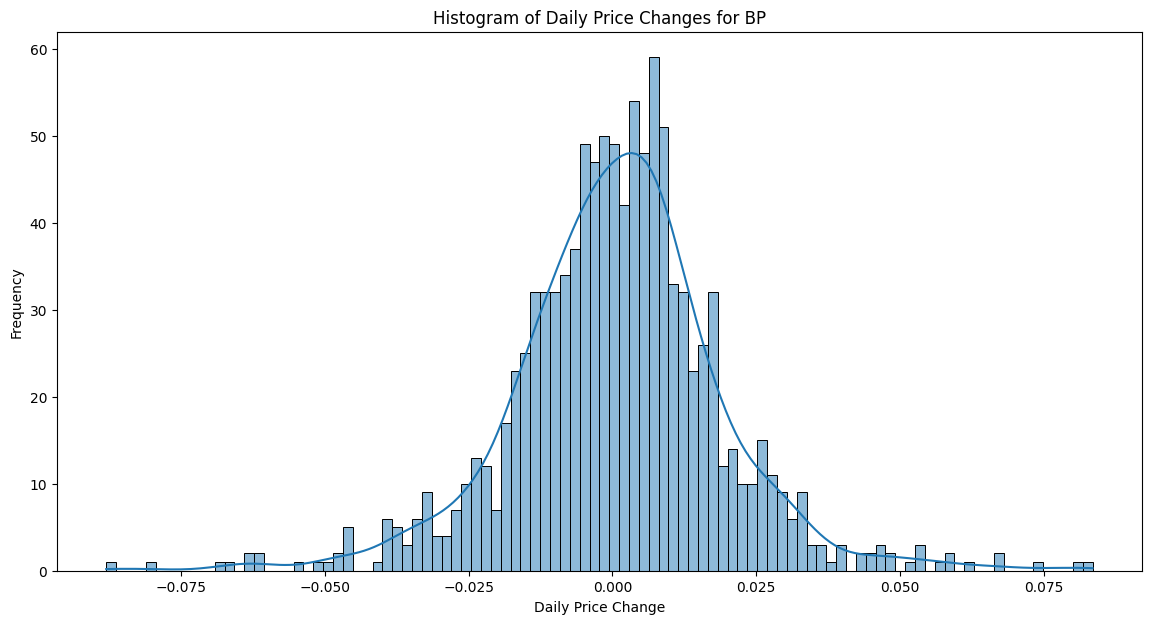

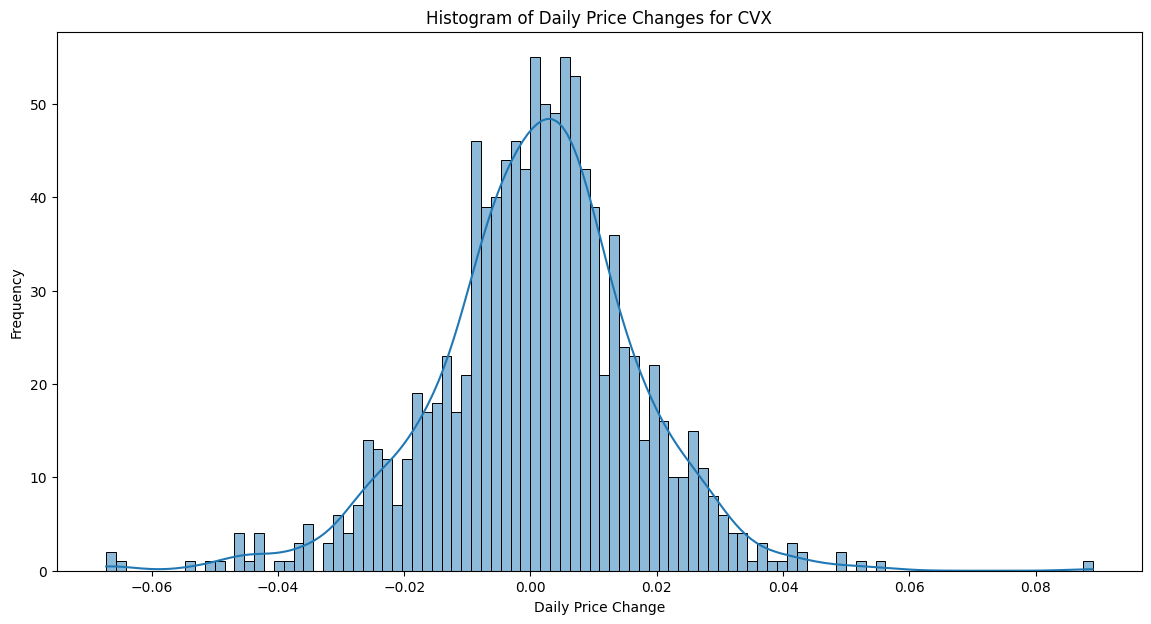

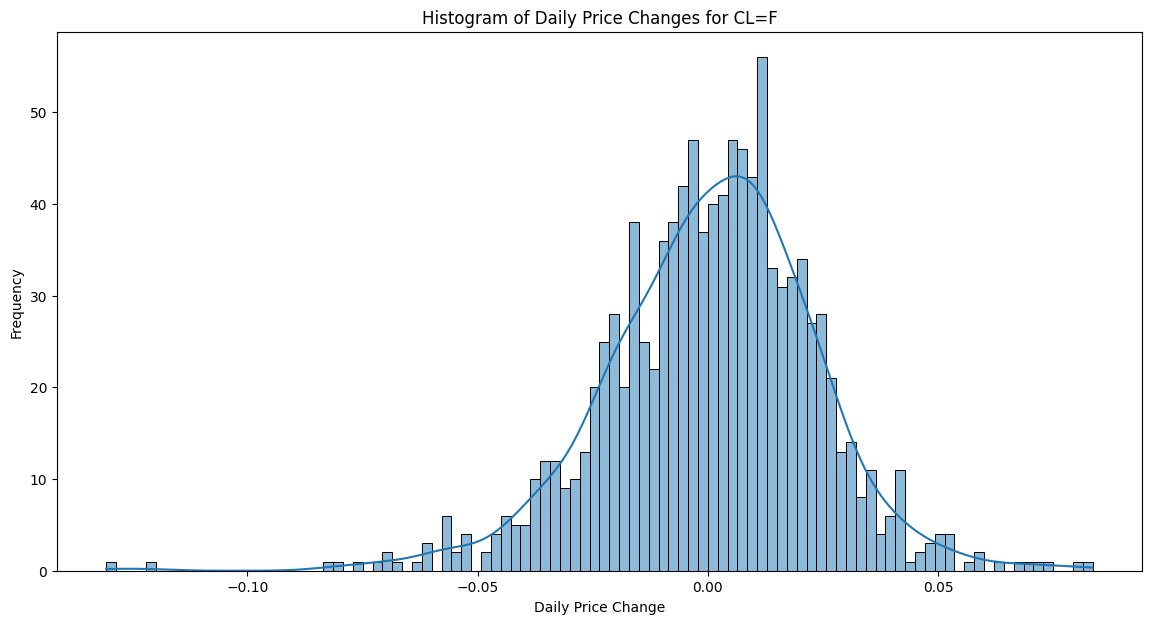

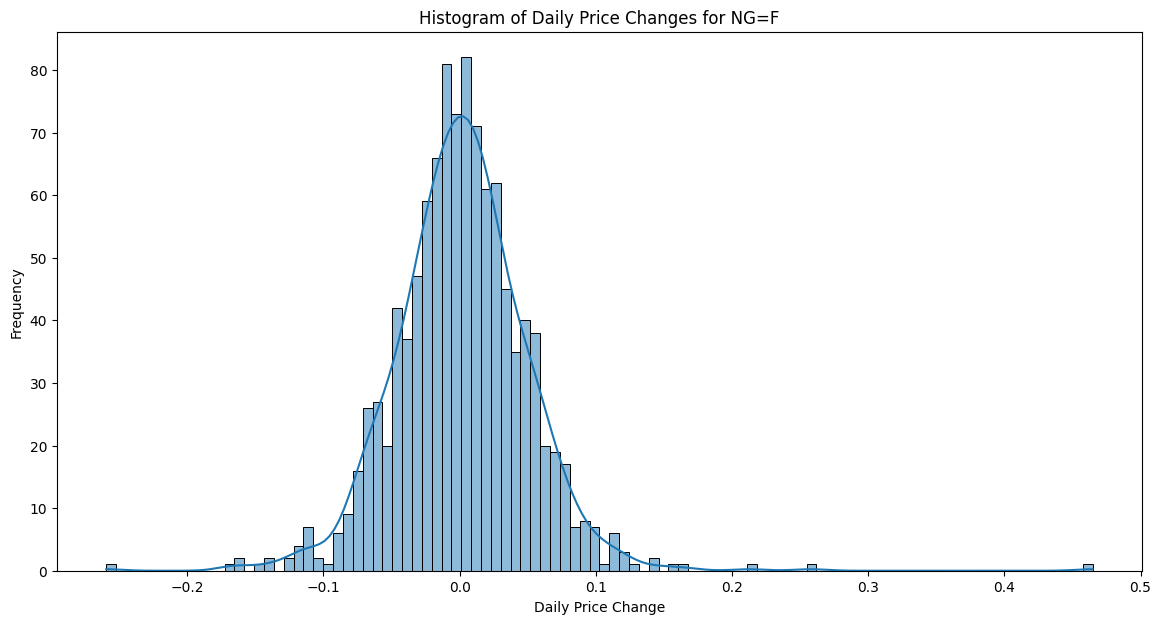

In [118]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.show()

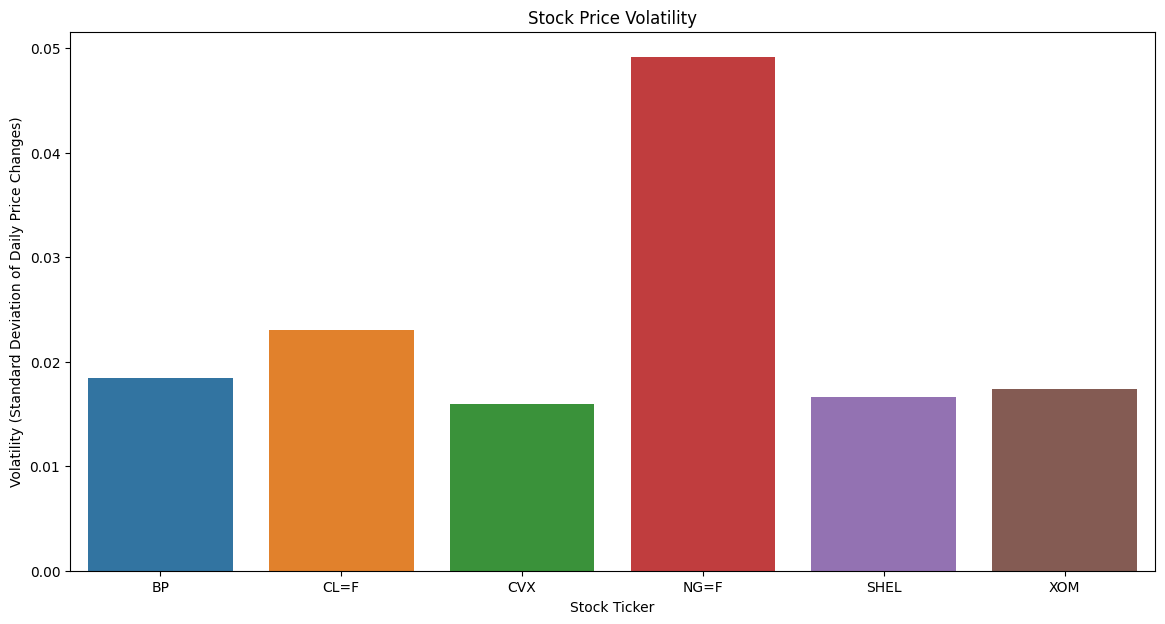

In [119]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.show()

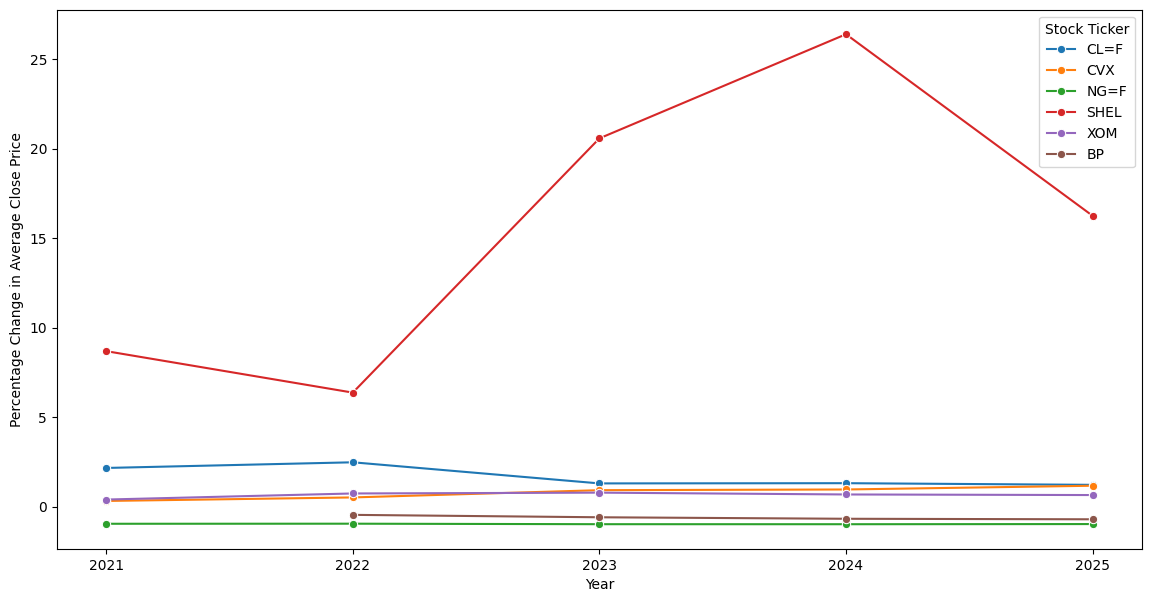

In [120]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.show()

## Shell

In [121]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

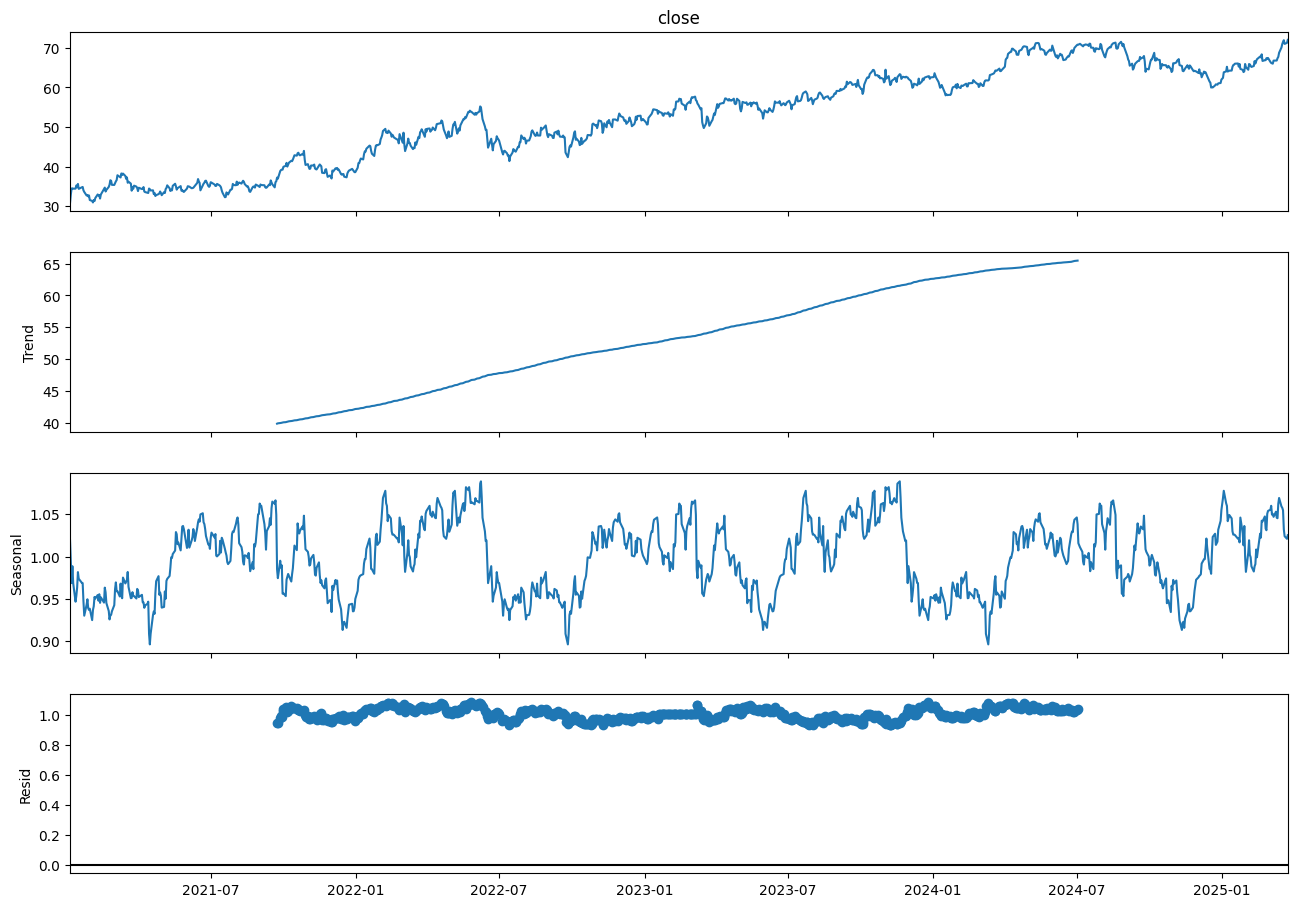

In [122]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

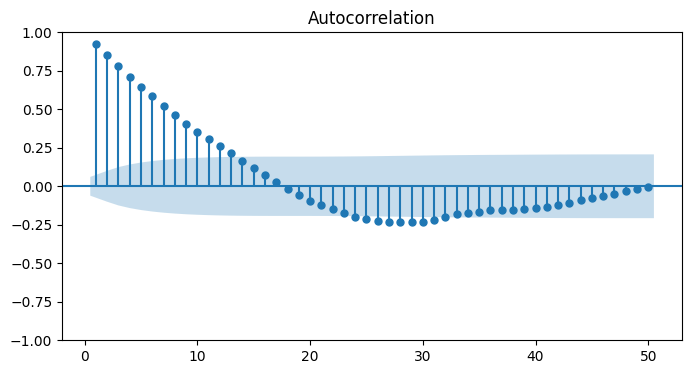

In [123]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

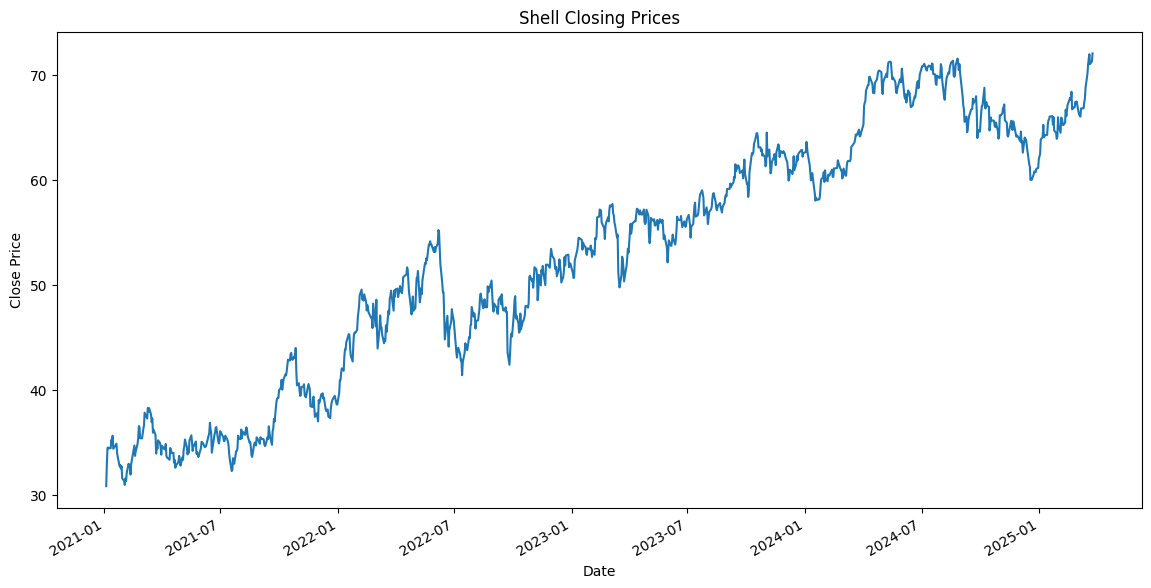

In [124]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_20452\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

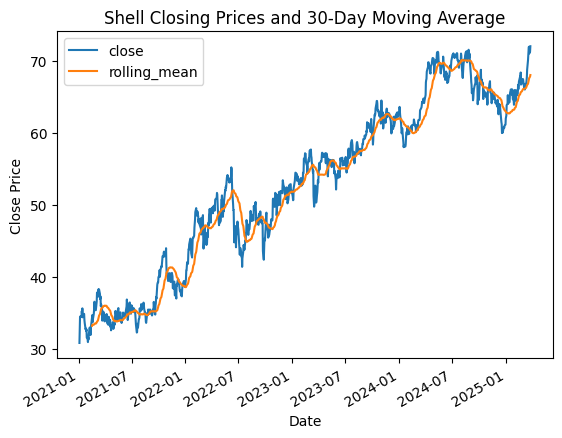

In [125]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [126]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

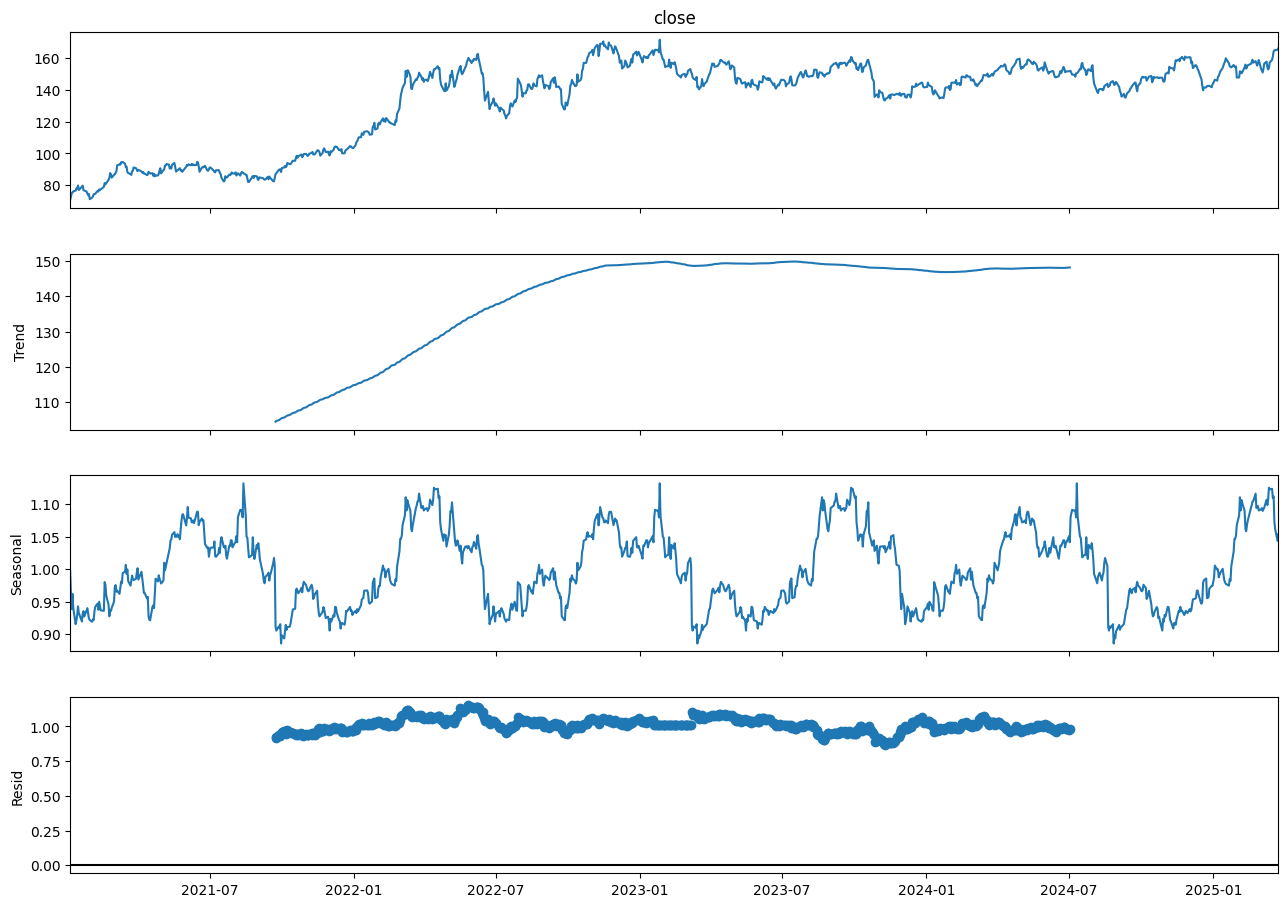

In [127]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

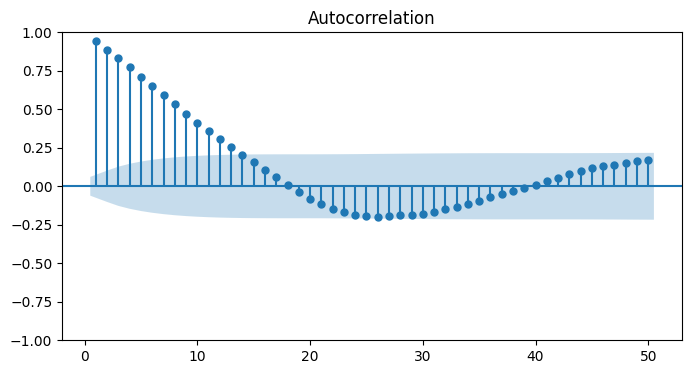

In [128]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

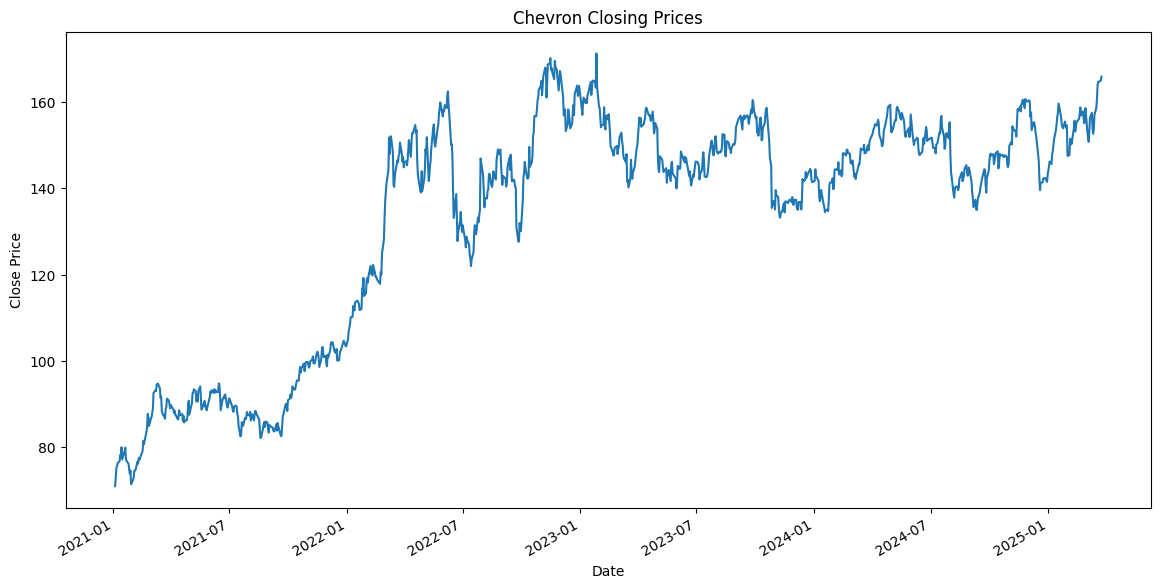

In [129]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_20452\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

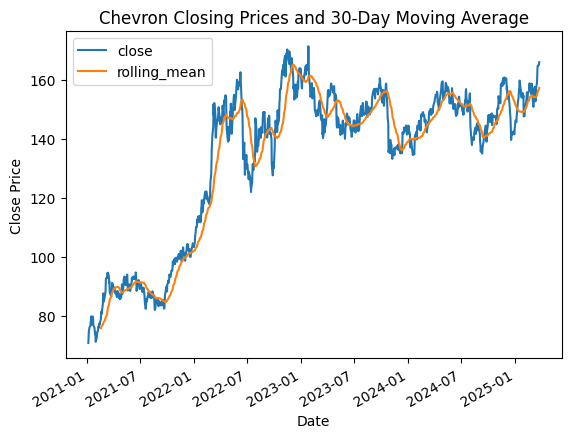

In [130]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ADF Test & PACF Plot & ACF Plot

adf test_p-value when d = 0: 0.6340253814909458
adf test_p-value when d = 1: 0.0
Final d = 1


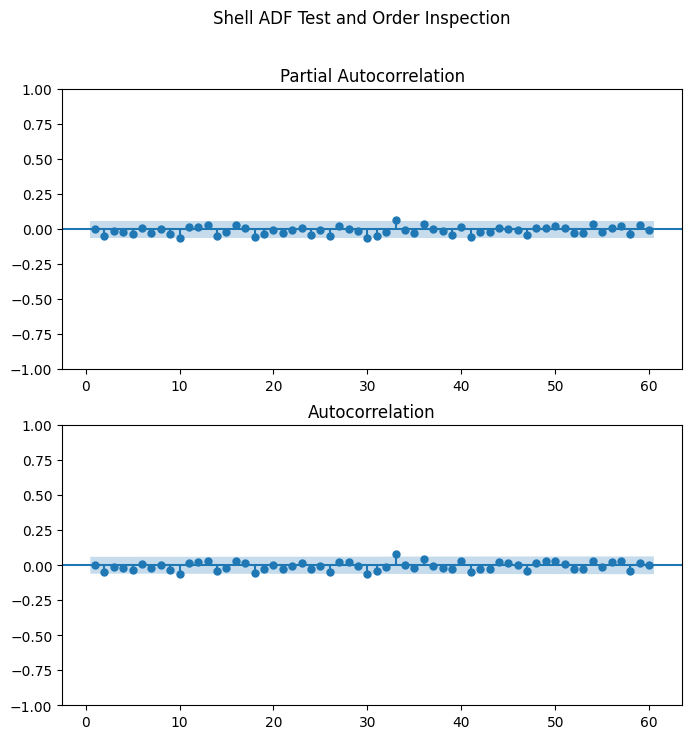

adf test_p-value when d = 0: 0.3589315316124665
adf test_p-value when d = 1: 0.0
Final d = 1


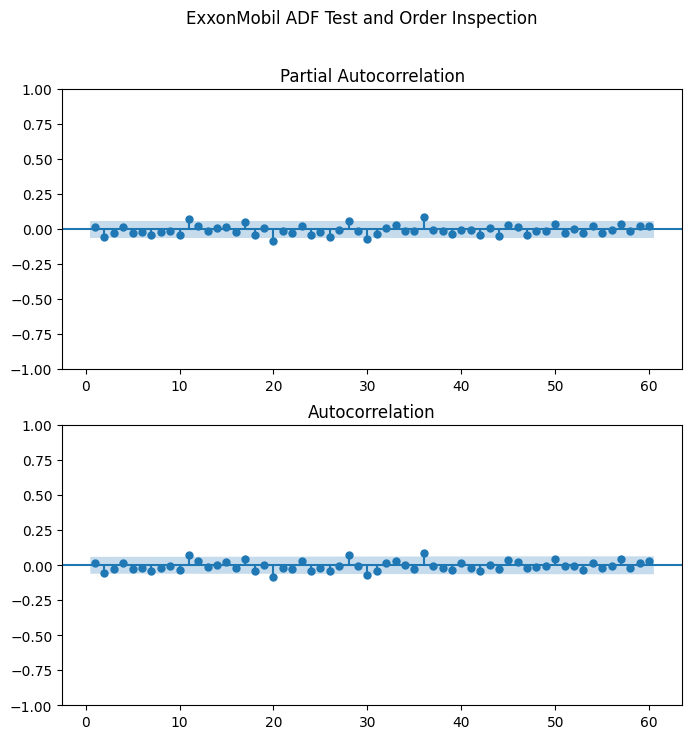

adf test_p-value when d = 0: 0.18858120211117801
adf test_p-value when d = 1: 0.0
Final d = 1


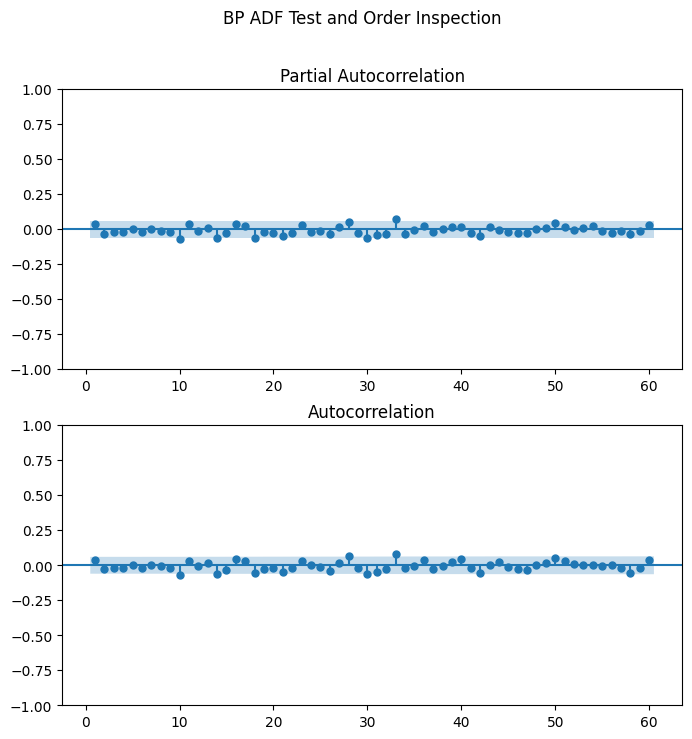

adf test_p-value when d = 0: 0.24643139090466504
adf test_p-value when d = 1: 0.0
Final d = 1


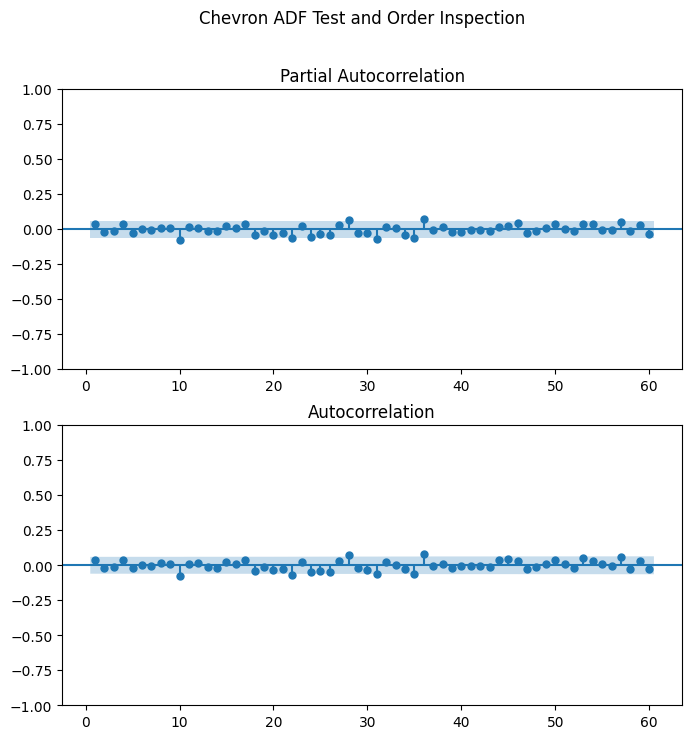

In [ ]:
stock_data.set_index('date', inplace = True)

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

# Prediction

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1276.393
Date:                Wed, 26 Mar 2025   AIC                           2554.786
Time:                        16:26:16   BIC                           2559.752
Sample:                             0   HQIC                          2556.669
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6508      0.021     30.414      0.000       0.609       0.693
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               123.70
Prob(Q):                              0.98   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

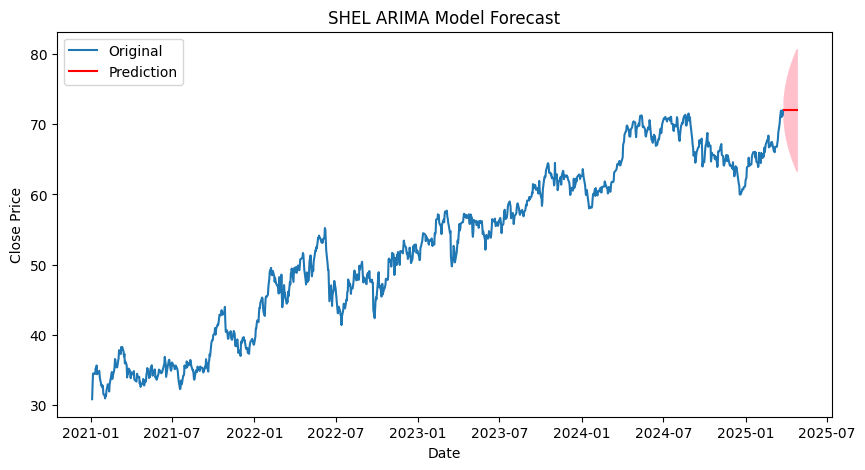

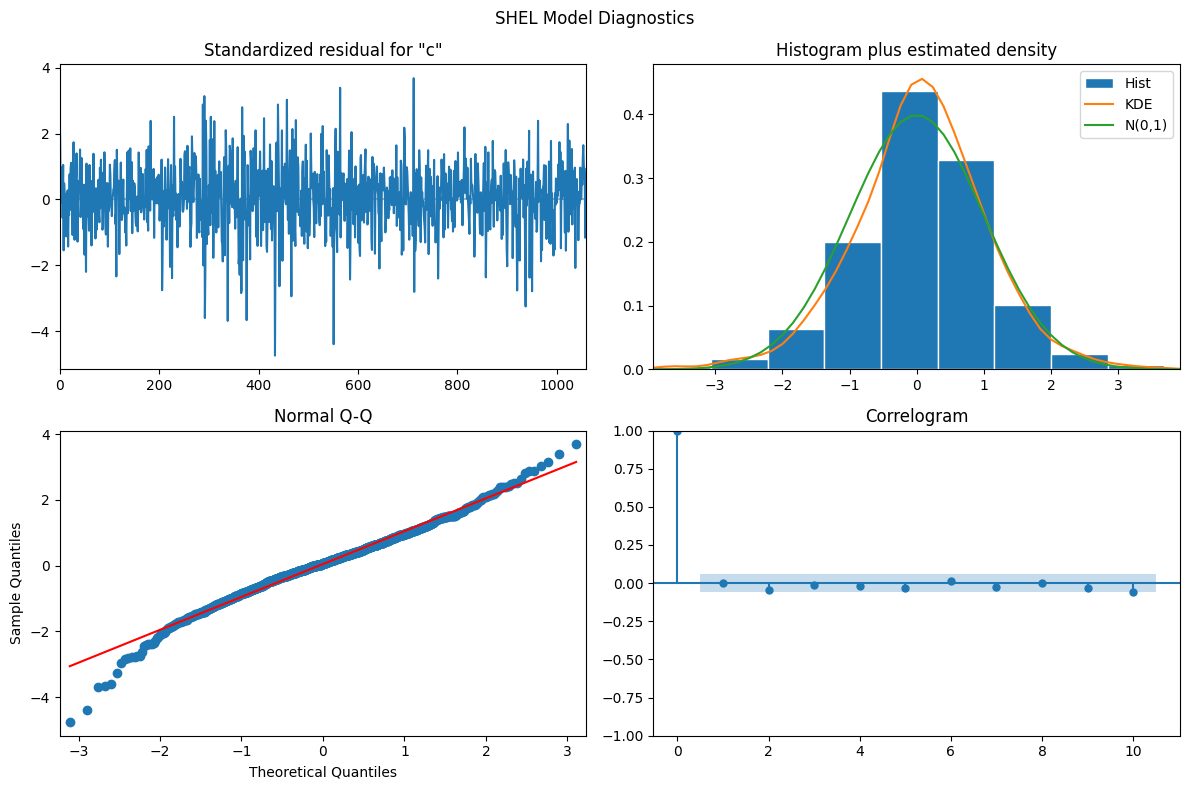

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1913.442
Date:                Wed, 26 Mar 2025   AIC                           3828.883
Time:                        16:26:17   BIC                           3833.849
Sample:                             0   HQIC                          3830.765
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1649      0.076     28.560      0.000       2.016       2.313
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                62.68
Prob(Q):                              0.55   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

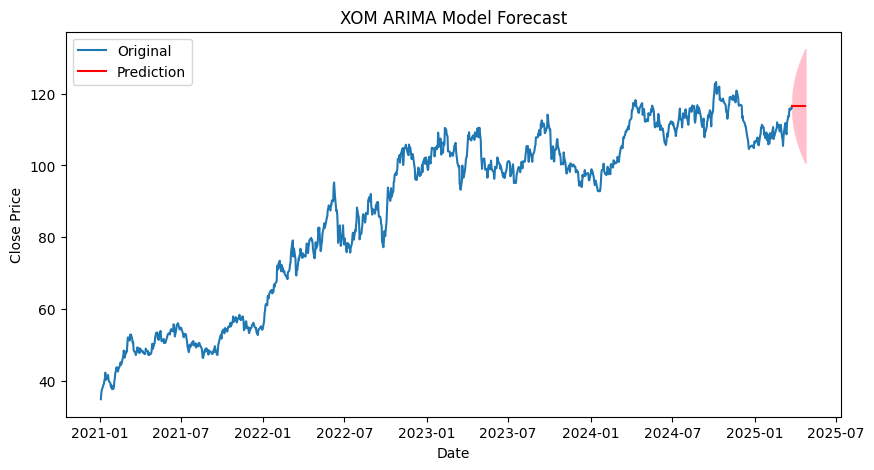

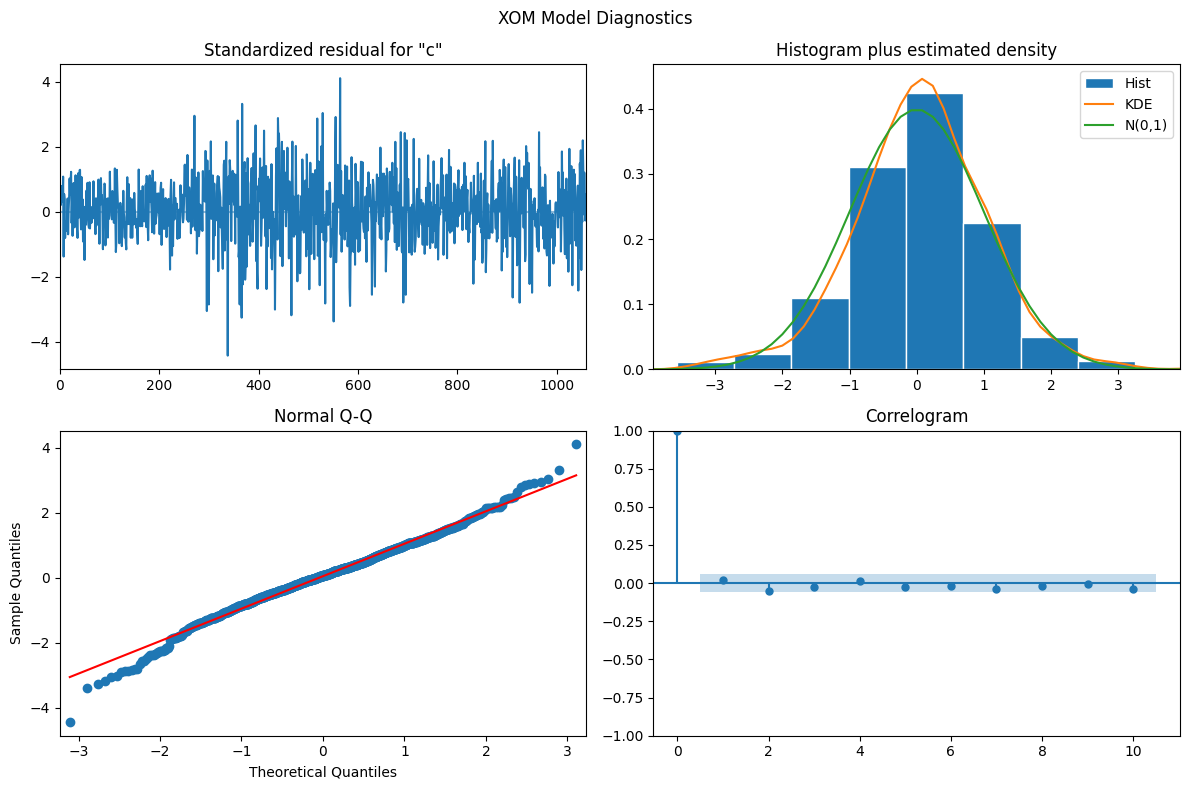

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -778.394
Date:                Wed, 26 Mar 2025   AIC                           1558.787
Time:                        16:26:18   BIC                           1563.753
Sample:                             0   HQIC                          1560.669
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2543      0.007     37.332      0.000       0.241       0.268
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               494.75
Prob(Q):                              0.22   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

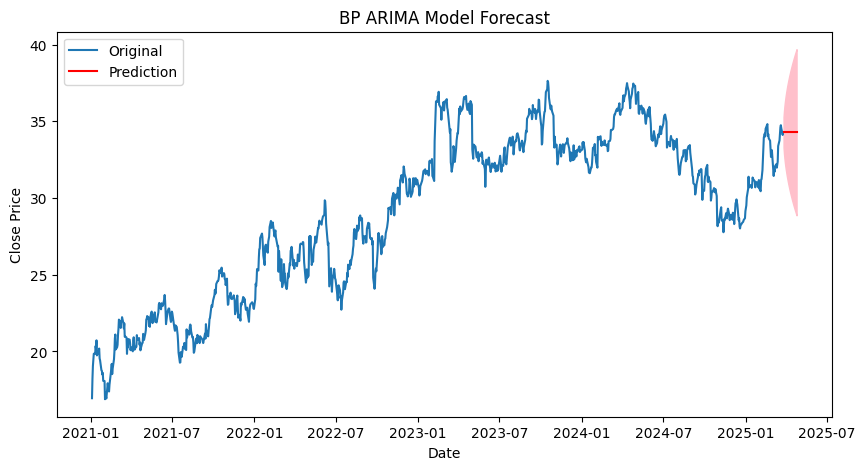

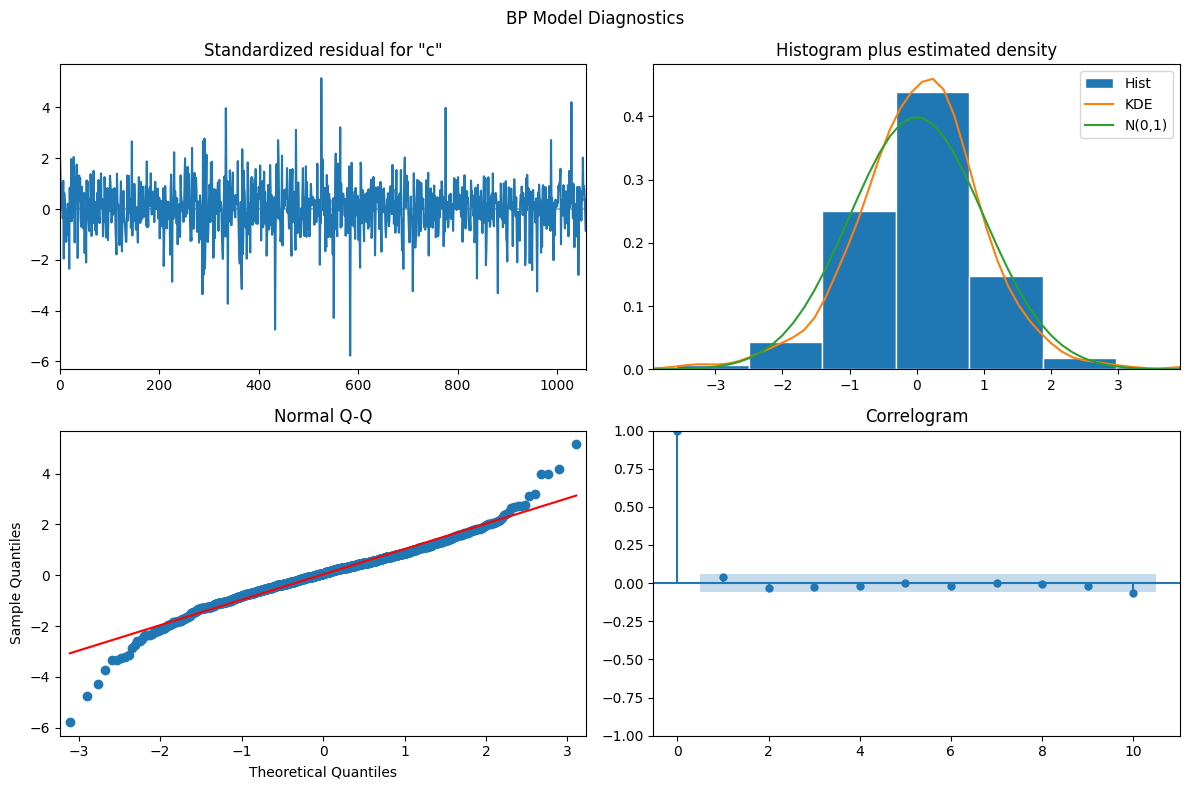

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2318.510
Date:                Wed, 26 Mar 2025   AIC                           4639.019
Time:                        16:26:19   BIC                           4643.985
Sample:                             0   HQIC                          4640.901
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.6491      0.130     35.672      0.000       4.394       4.904
Ljung-Box (L1) (Q):                   1.73   Jarque-Bera (JB):               387.90
Prob(Q):                              0.19   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

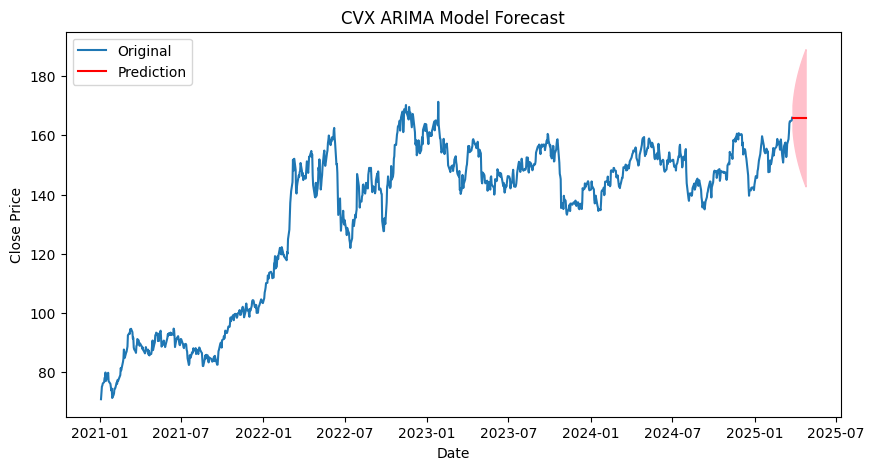

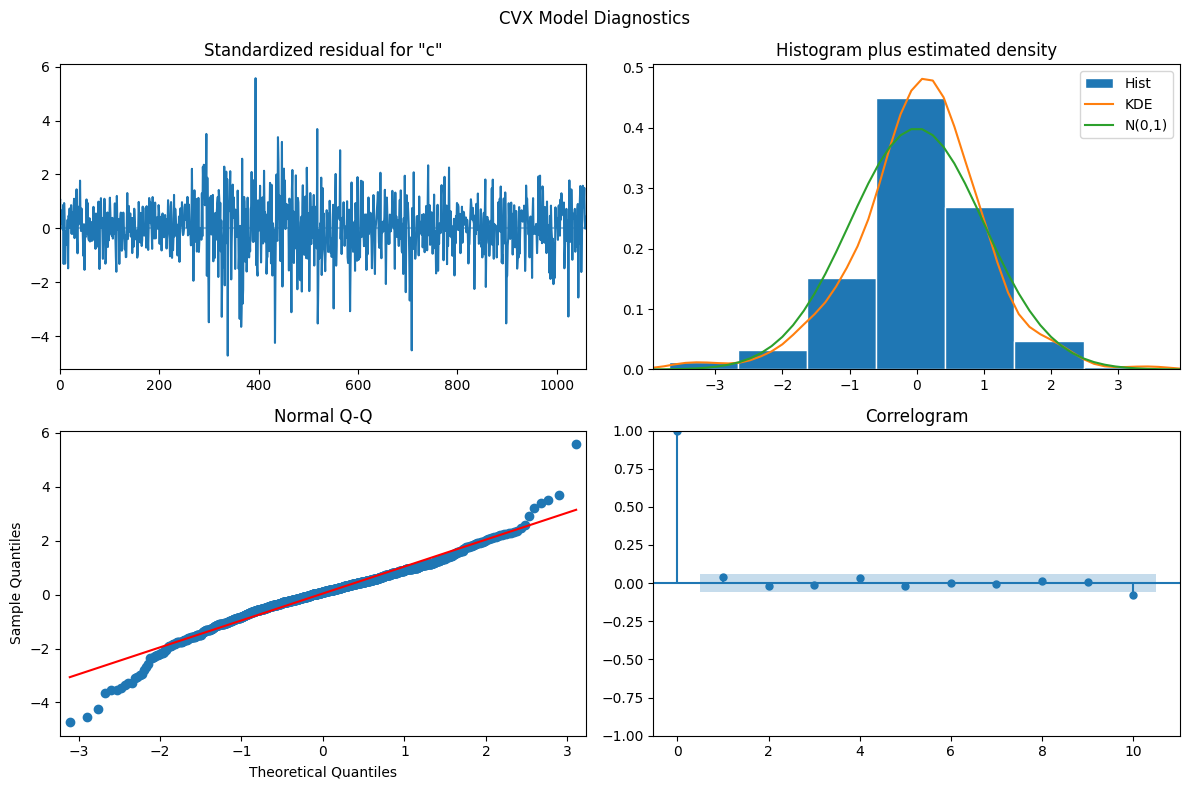

In [31]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






## Prediction with Train Test Split


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  848
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1031.751
Date:                Wed, 26 Mar 2025   AIC                           2065.502
Time:                        17:21:01   BIC                           2070.244
Sample:                             0   HQIC                          2067.319
                                - 848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6692      0.024     27.648      0.000       0.622       0.717
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               109.79
Prob(Q):                  

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

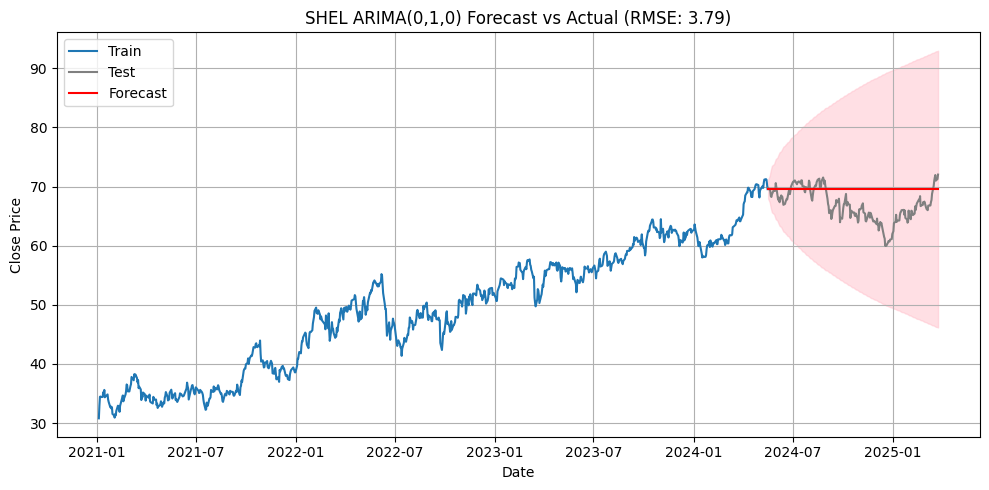

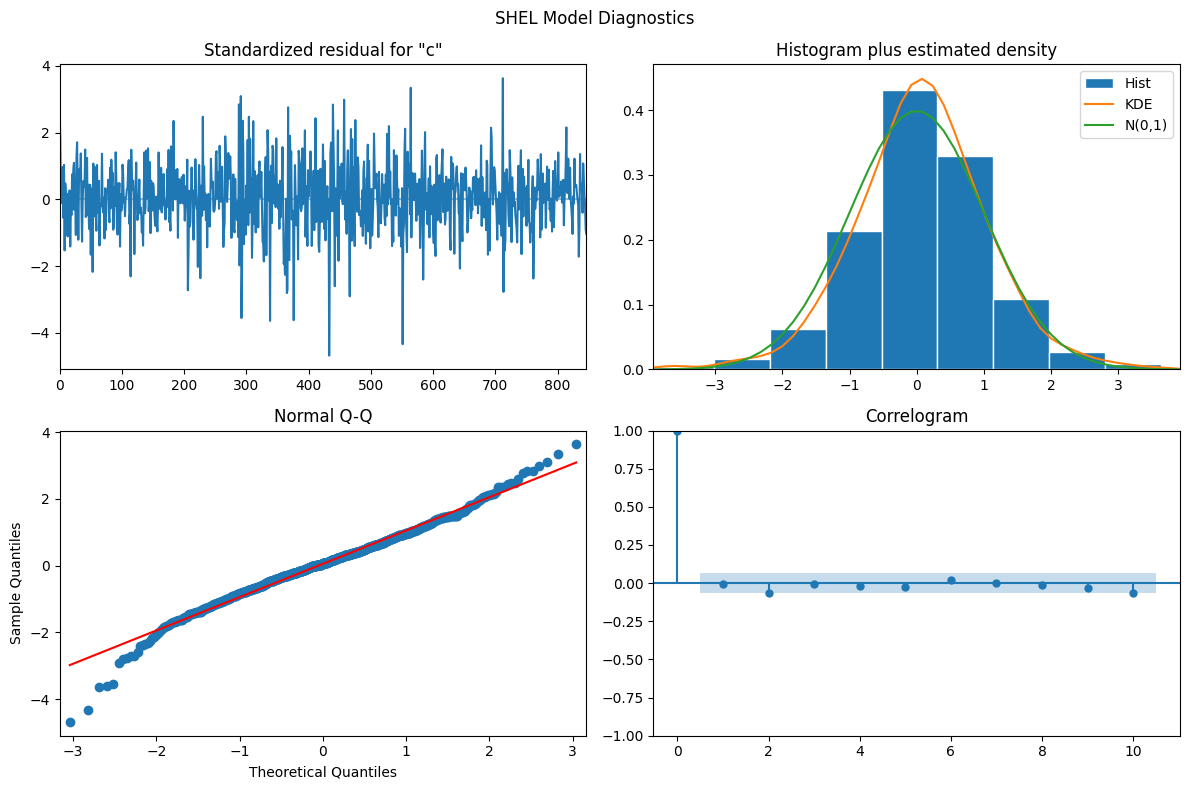


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  848
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1527.743
Date:                Wed, 26 Mar 2025   AIC                           3057.485
Time:                        17:21:01   BIC                           3062.227
Sample:                             0   HQIC                          3059.302
                                - 848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1588      0.081     26.675      0.000       2.000       2.317
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                77.06
Prob(Q):                   

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

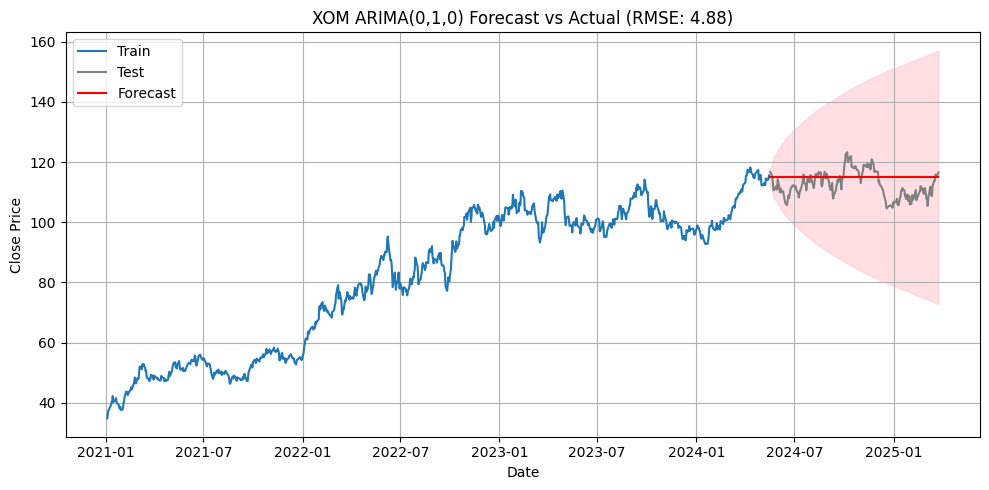

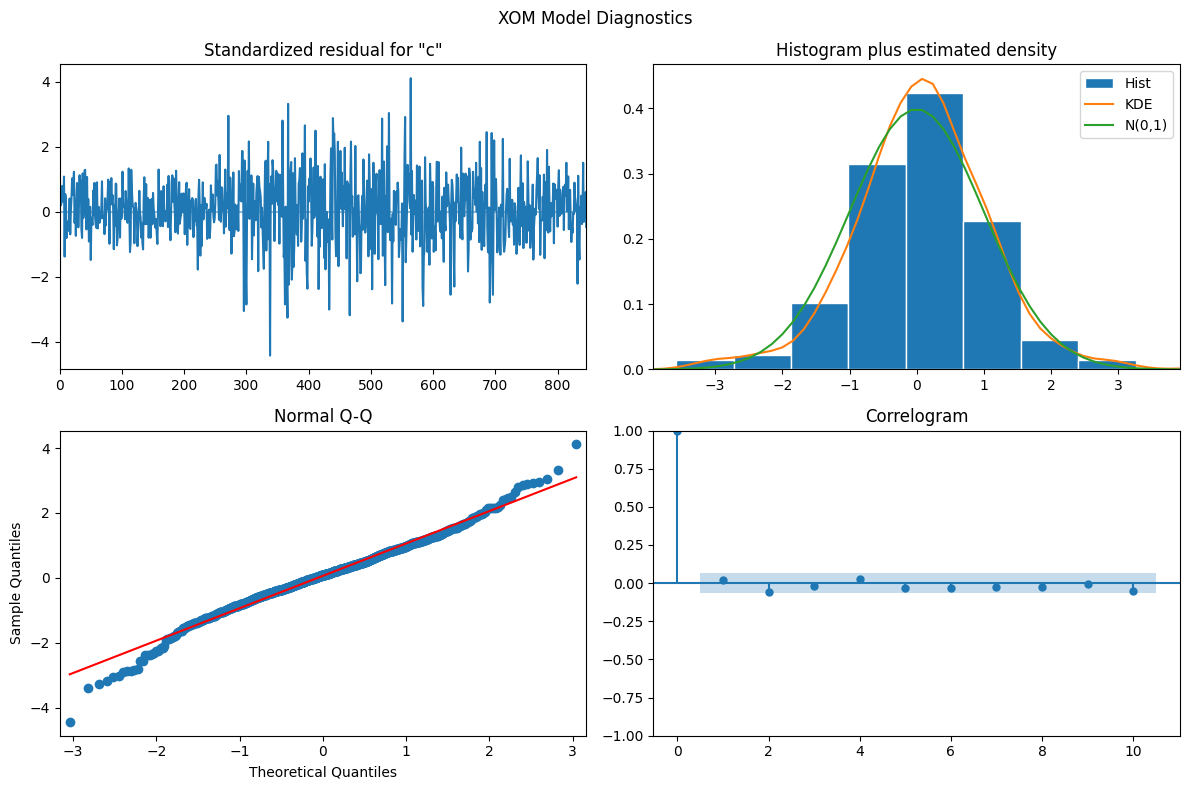


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  848
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -636.092
Date:                Wed, 26 Mar 2025   AIC                           1274.184
Time:                        17:21:02   BIC                           1278.926
Sample:                             0   HQIC                          1276.000
                                - 848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2629      0.008     33.486      0.000       0.248       0.278
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               407.51
Prob(Q):                    

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

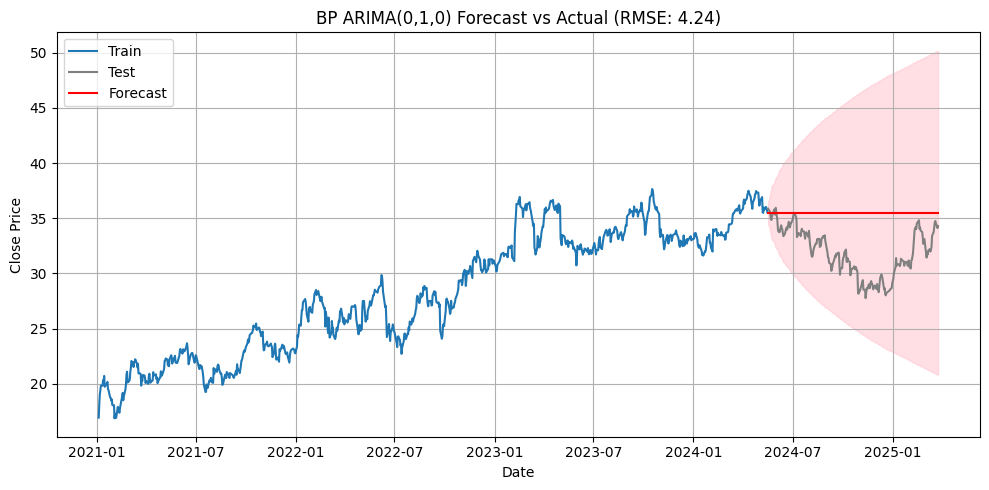

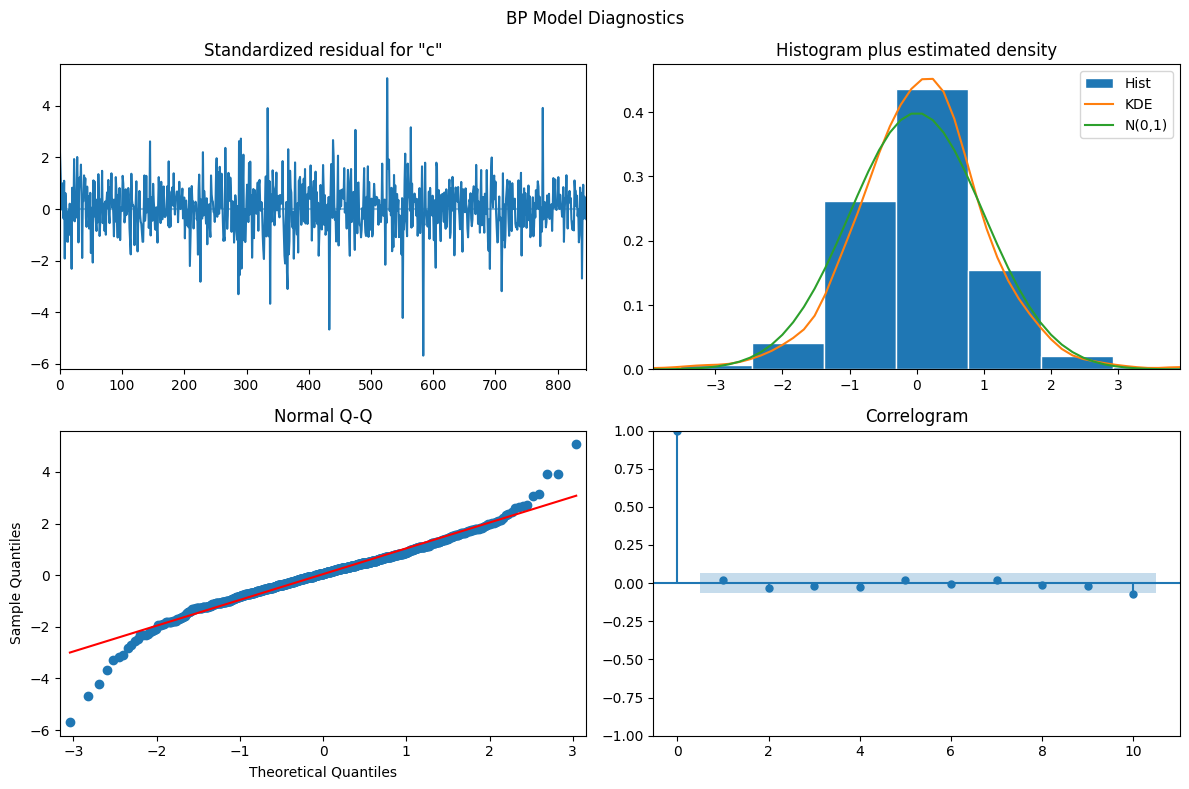

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  848
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1870.784
Date:                Wed, 26 Mar 2025   AIC                           3743.568
Time:                        17:21:02   BIC                           3748.309
Sample:                             0   HQIC                          3745.384
                                - 848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.8528      0.149     32.556      0.000       4.561       5.145
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               347.12
Prob(Q):                   

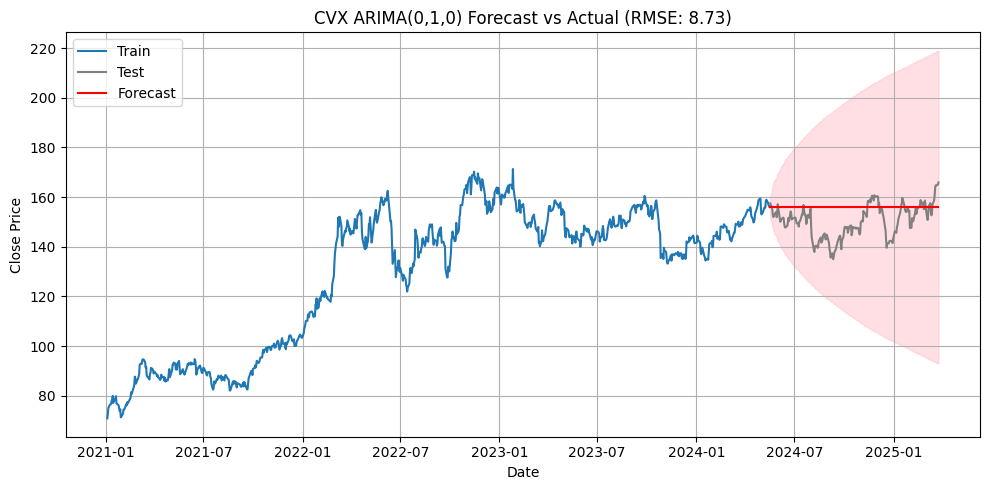

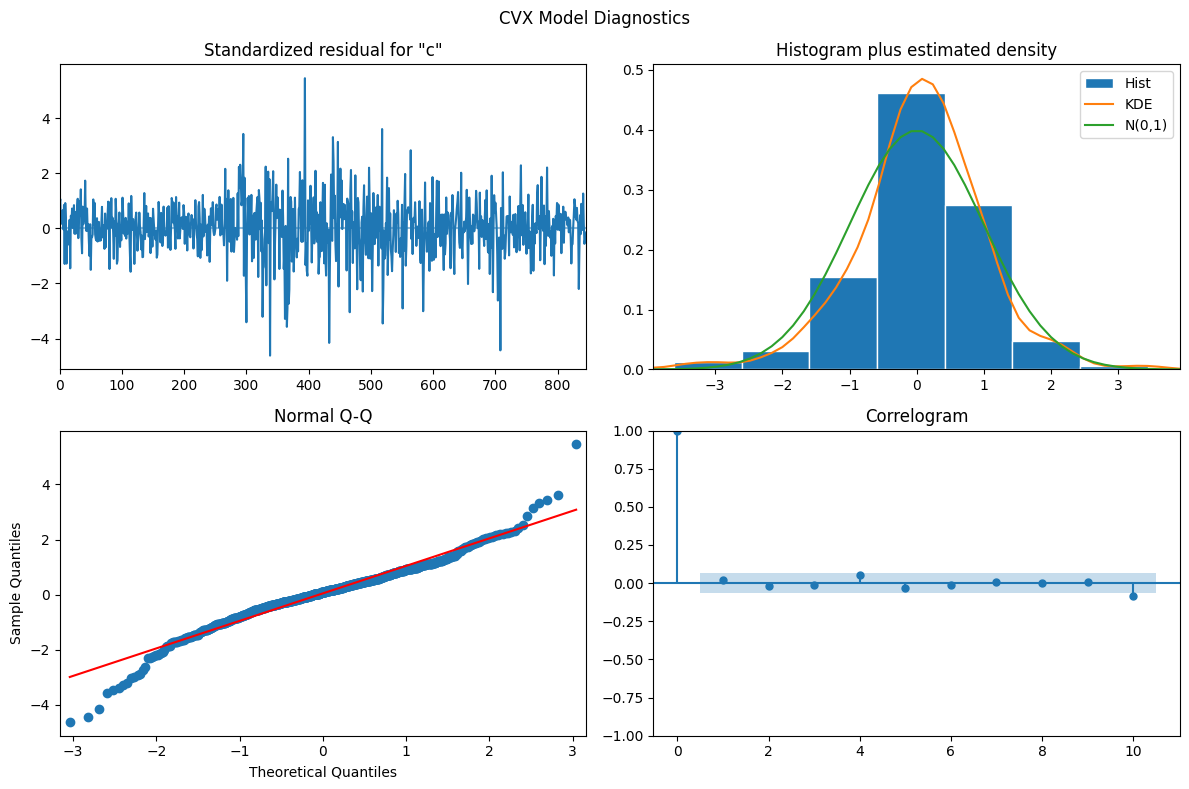

In [ ]:
# ARIMA Model with Train Test Split
stock_data.set_index('date', inplace = True)

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(0, 1, 0))
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()

## Prediction with Crude Oil Price Data

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  834
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -878.797
Date:                Wed, 26 Mar 2025   AIC                           1761.594
Time:                        21:10:02   BIC                           1771.044
Sample:                             0   HQIC                          1765.217
                                - 834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2077      0.007     27.700      0.000       0.193       0.222
sigma2         0.4829      0.016     29.481      0.000       0.451       0.515
Ljung-Box (L1) (Q):            

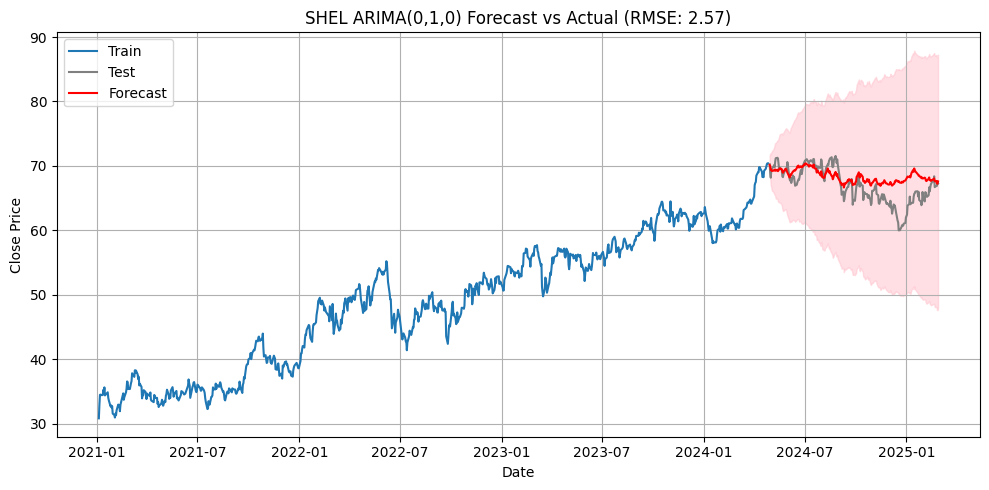

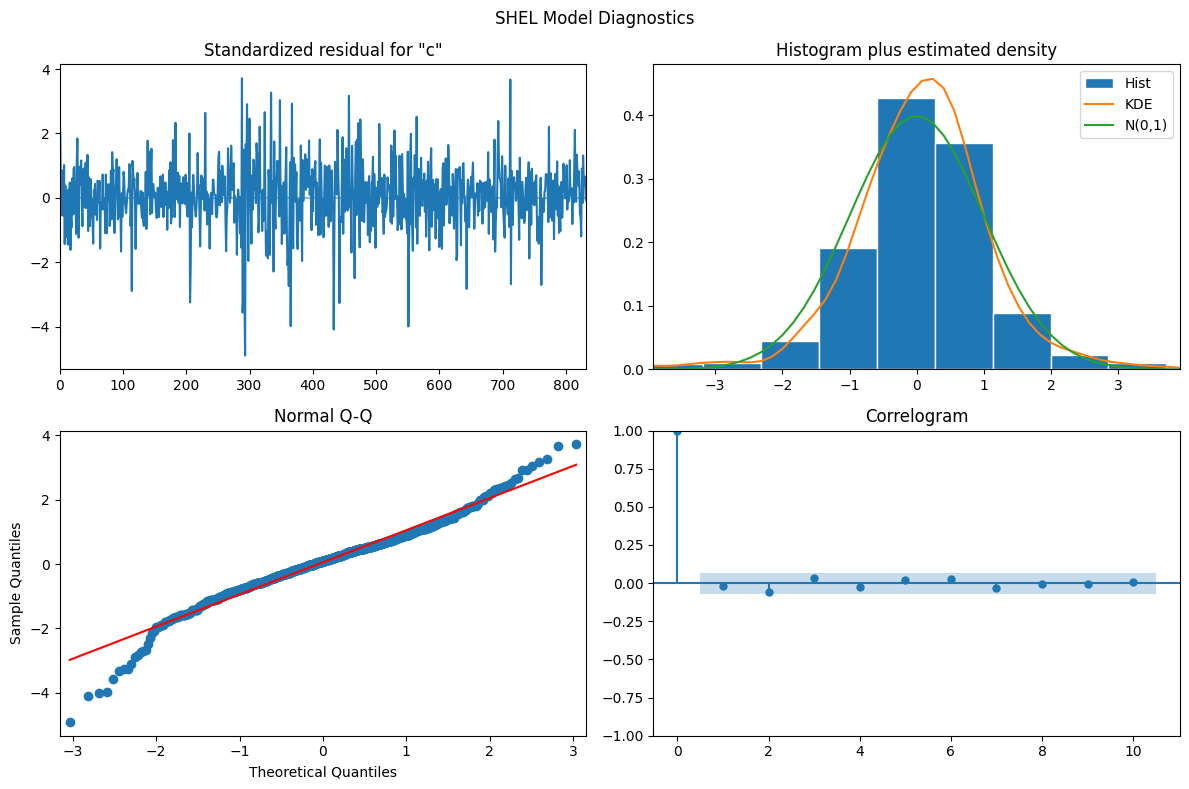

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  834
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1318.710
Date:                Wed, 26 Mar 2025   AIC                           2641.420
Time:                        21:10:03   BIC                           2650.870
Sample:                             0   HQIC                          2645.043
                                - 834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4226      0.015     28.168      0.000       0.393       0.452
sigma2         1.3886      0.053     26.166      0.000       1.285       1.493
Ljung-Box (L1) (Q):             

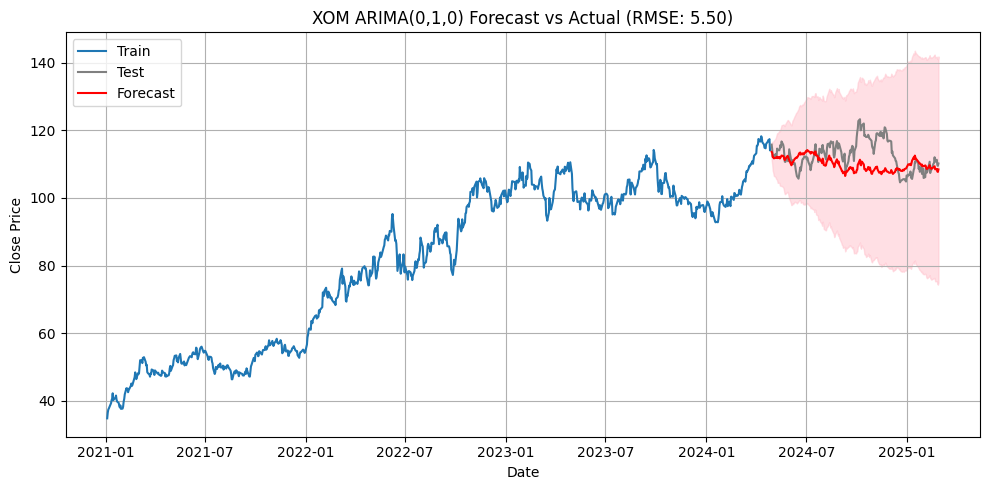

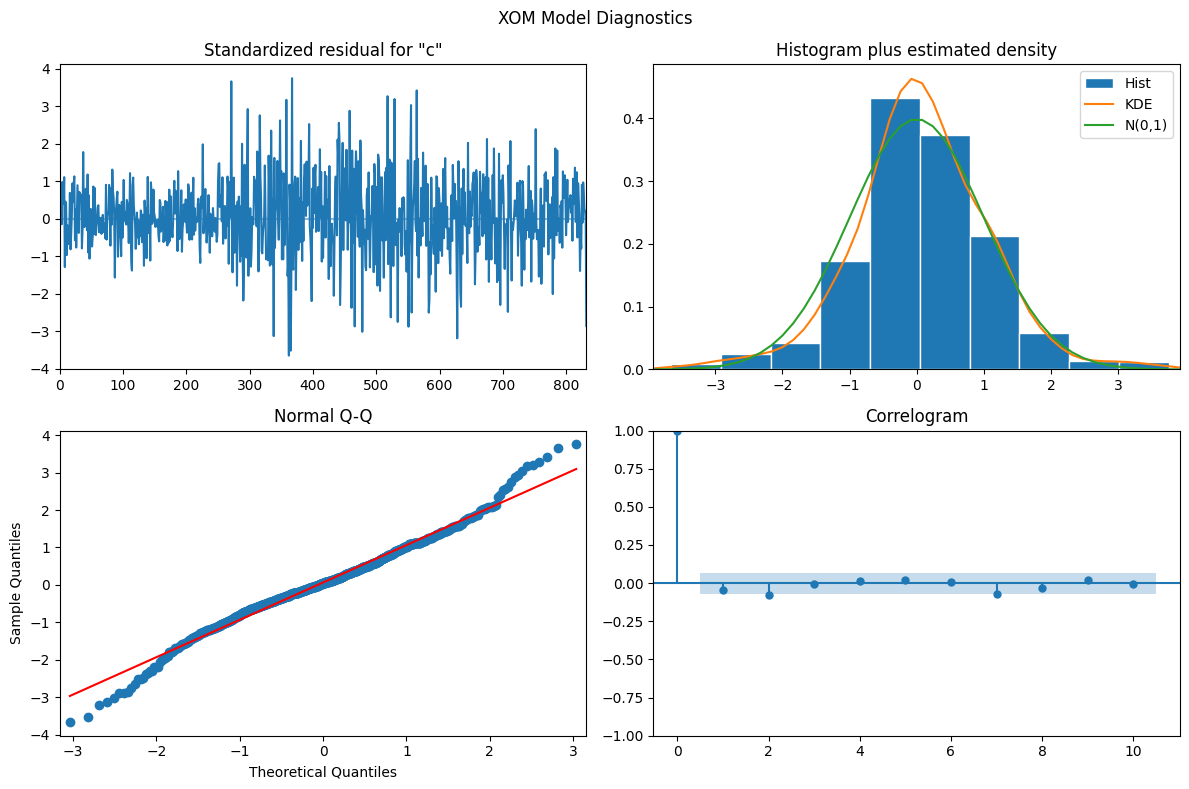

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  834
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -491.784
Date:                Wed, 26 Mar 2025   AIC                            987.568
Time:                        21:10:04   BIC                            997.018
Sample:                             0   HQIC                           991.191
                                - 834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.1285      0.005     27.596      0.000       0.119       0.138
sigma2         0.1907      0.005     37.199      0.000       0.181       0.201
Ljung-Box (L1) (Q):              

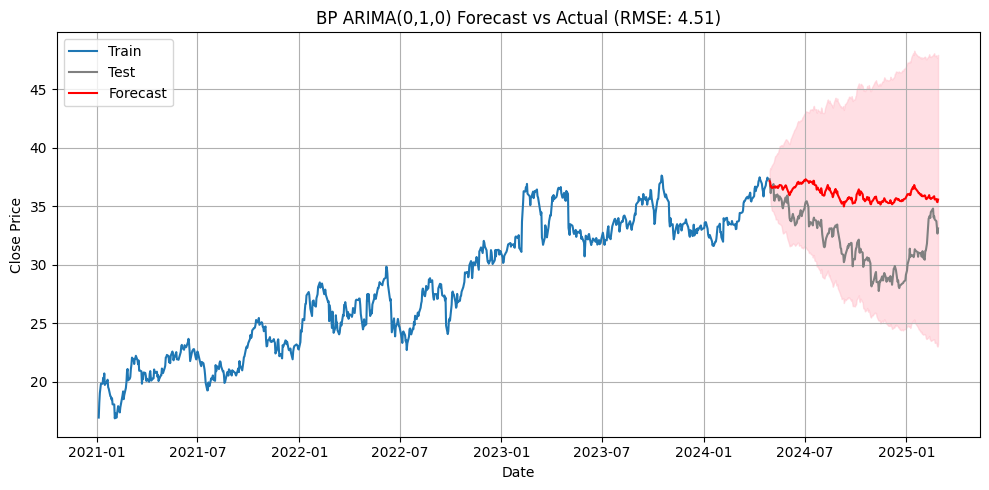

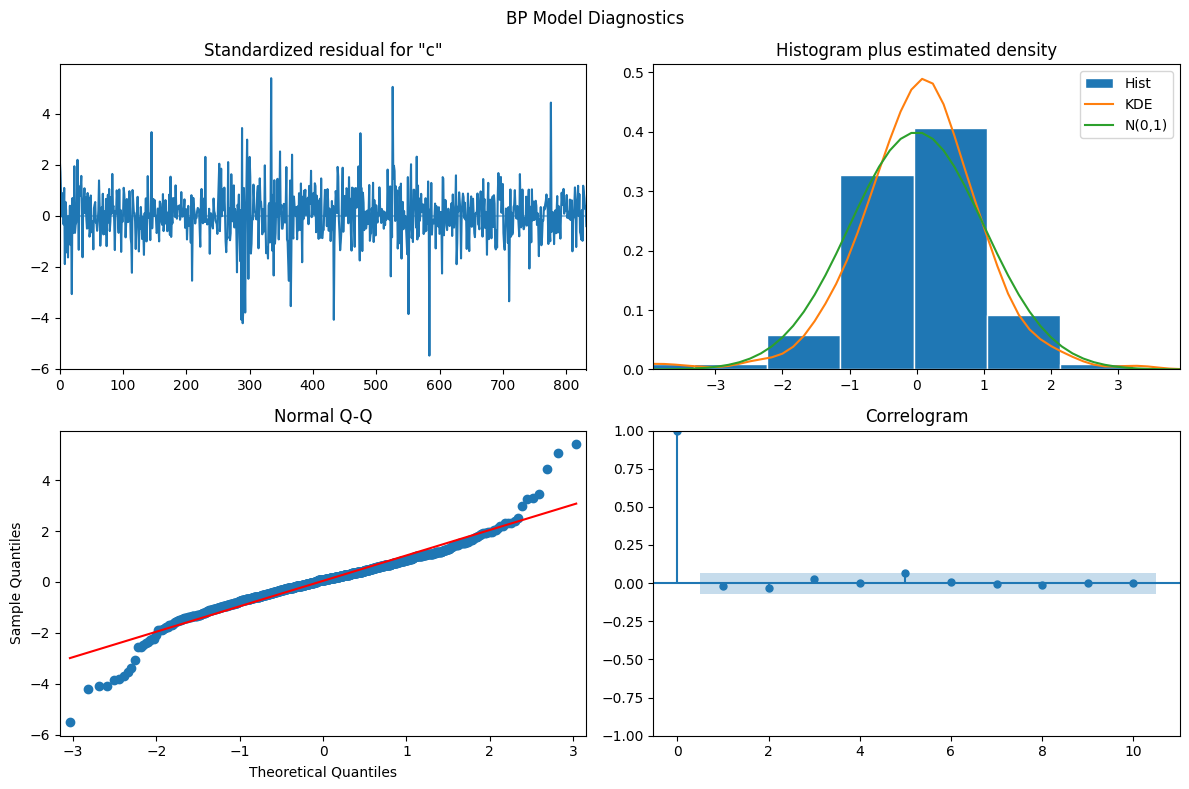

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  834
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1692.575
Date:                Wed, 26 Mar 2025   AIC                           3389.149
Time:                        21:10:06   BIC                           3398.599
Sample:                             0   HQIC                          3392.773
                                - 834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.5791      0.022     26.166      0.000       0.536       0.623
sigma2         3.4073      0.091     37.386      0.000       3.229       3.586
Ljung-Box (L1) (Q):             

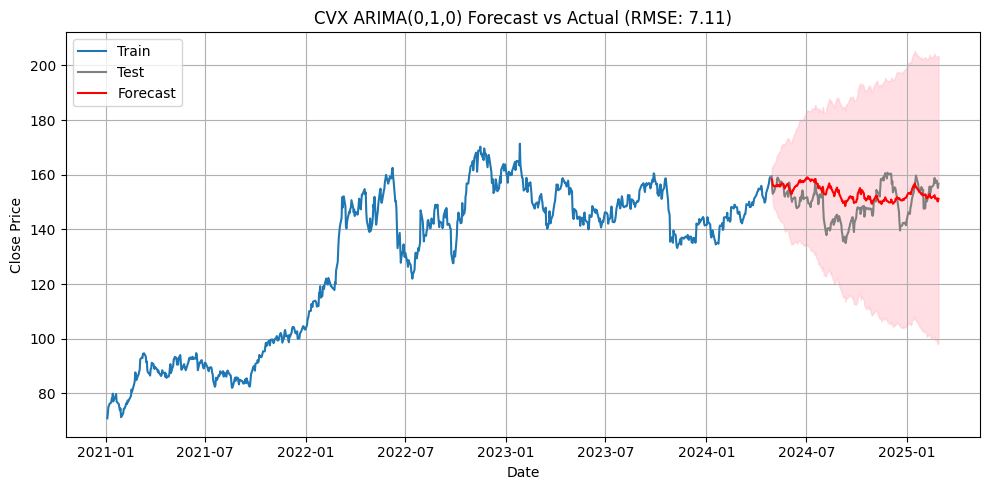

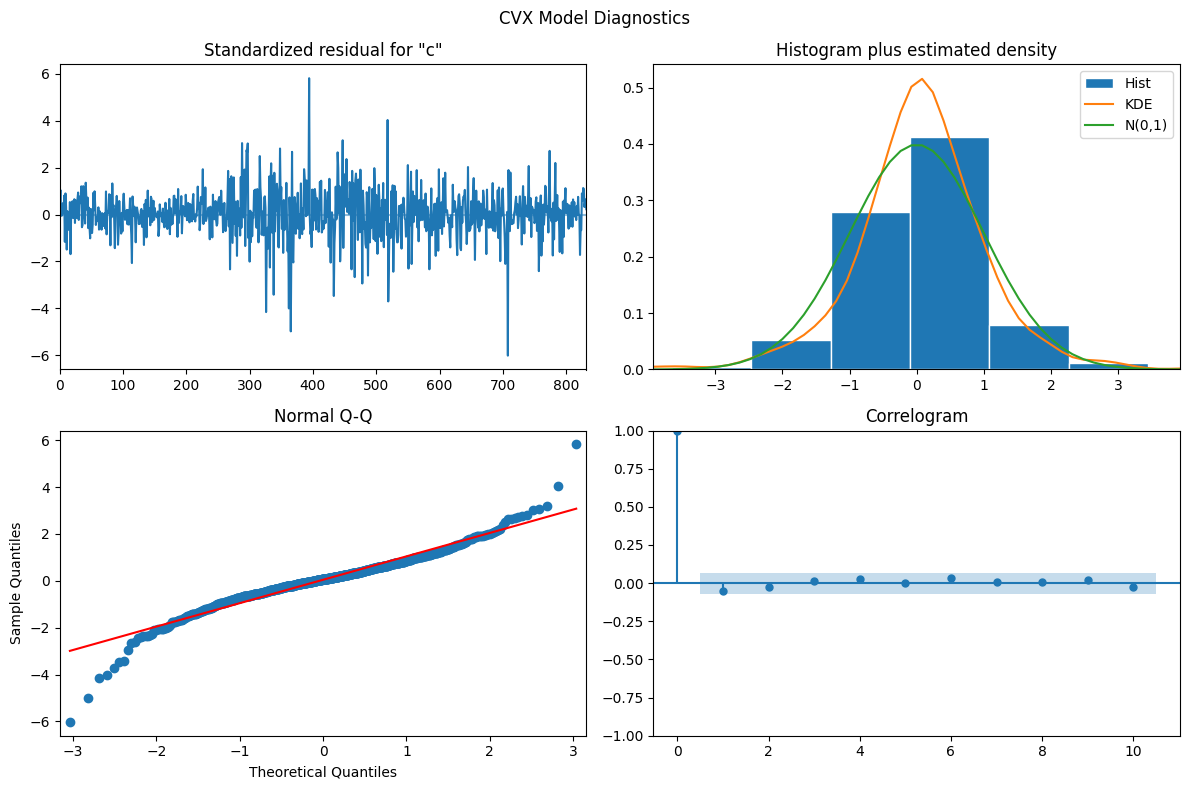

In [ ]:
for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='CL=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()